In [1484]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from UnifiedMomentumModel.Momentum import UnifiedMomentum

# Analytical Models

## Define Analytical Models

In [1485]:
def classical(ctp):  # return Cp for classical momentum theory
    a = ctp / (4 + ctp)
    return 4 * a * (1 - a)**2

In [1486]:
def johlas(ctp, sa, pa):  # return Cp for classical momentum theory adjusted by coefficents in Johlas 2020
    cp = classical(ctp)
    x_disp = (1 + (3 * (sa**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp  # coefficents from turbine movement

In [1487]:
def umm(ctp, sf, sa, pa):
    model = UnifiedMomentum()
    sf_rad = np.deg2rad(sf)
    sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
    sa_vals = (sa * sin_vals) + 1
    sa_vals_cubed = sa_vals**3
    pa_vals = np.deg2rad(pa) * sin_vals
    umm_vals = np.array([np.mean(sa_vals_cubed * model(Ctprime = c, yaw = 0.0, tilt = pa_vals).Cp) for c in np.atleast_1d(ctp)])
    return umm_vals

## Plot Analytical Models

In [1488]:
palette =['tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:red']

### For this initial exploration, we will use $f = 1.0$ and $A_S = 0.5$ & $A_P = 5^\circ$. 

In [1489]:
ctp_list = np.linspace(0.01, 10, num = 100)

In [1490]:
def fix_plot_legend(ax, xOffset = 1.85, title = ""):
    leg = ax.legend(title = title)
    bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
    return

In [1491]:
def plot_mean_cp_models(ctp_list, f, sa, pa, palette = palette):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (10, 4), dpi = 300)
    fig.suptitle("Mean $C_P$ vs $C_T^'$", size = 16, y = 1.04)
    ax0.set_title(f"Surging ($f = {f}$, A = ${sa}$)", size = 14, y = 1.04)
    ax1.set_title(f"Pitching ($f = {f}$, A = ${pa}^\circ$)", size = 14, y = 1.04)
    ax0.set_xlabel('$C_T^\'$', size = 15)
    ax1.set_xlabel('$C_T^\'$', size = 15)
    ax0.set_ylabel('Mean $C_P$', size = 15)
    ax1.set_ylabel('Mean $C_P$', size = 15)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax0.set_ylim(0, 1)
    linewidth = 3.5

    classical_cp = classical(ctp_list)
    # plot surging
    johlas_cp_surge = johlas(ctp_list, sa, 0)
    umm_cp_surge = umm(ctp_list, f, sa, 0)
    sns.lineplot(ax = ax0, x = ctp_list, y = classical_cp, color=palette[0], label = "Classical", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = johlas_cp_surge, color=palette[1], label = "Johlas", linewidth = linewidth)
    sns.lineplot(ax = ax0, x = ctp_list, y = umm_cp_surge, color=palette[2], label = "Quasi-Steady UMM", linewidth = linewidth)

    # plot pitching
    johlas_cp_pitch = johlas(ctp_list, 0, pa)
    umm_cp_pitch = umm(ctp_list, f, 0, pa)
    sns.lineplot(ax = ax1, x = ctp_list, y = classical_cp, color=palette[0], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = johlas_cp_pitch, color=palette[1], linewidth = linewidth, legend=False)
    sns.lineplot(ax = ax1, x = ctp_list, y = umm_cp_pitch, color=palette[2], linewidth = linewidth, legend=False)

    # adjust plot legend and spacing
    fix_plot_legend(ax0)
    fig.subplots_adjust(wspace=0.25)
    return fig, (ax0, ax1)


/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value encountered in divide
  sin_a = np.where(tilt == 0, 0, -(np.sin(tilt) * np.cos(yaw)) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value 

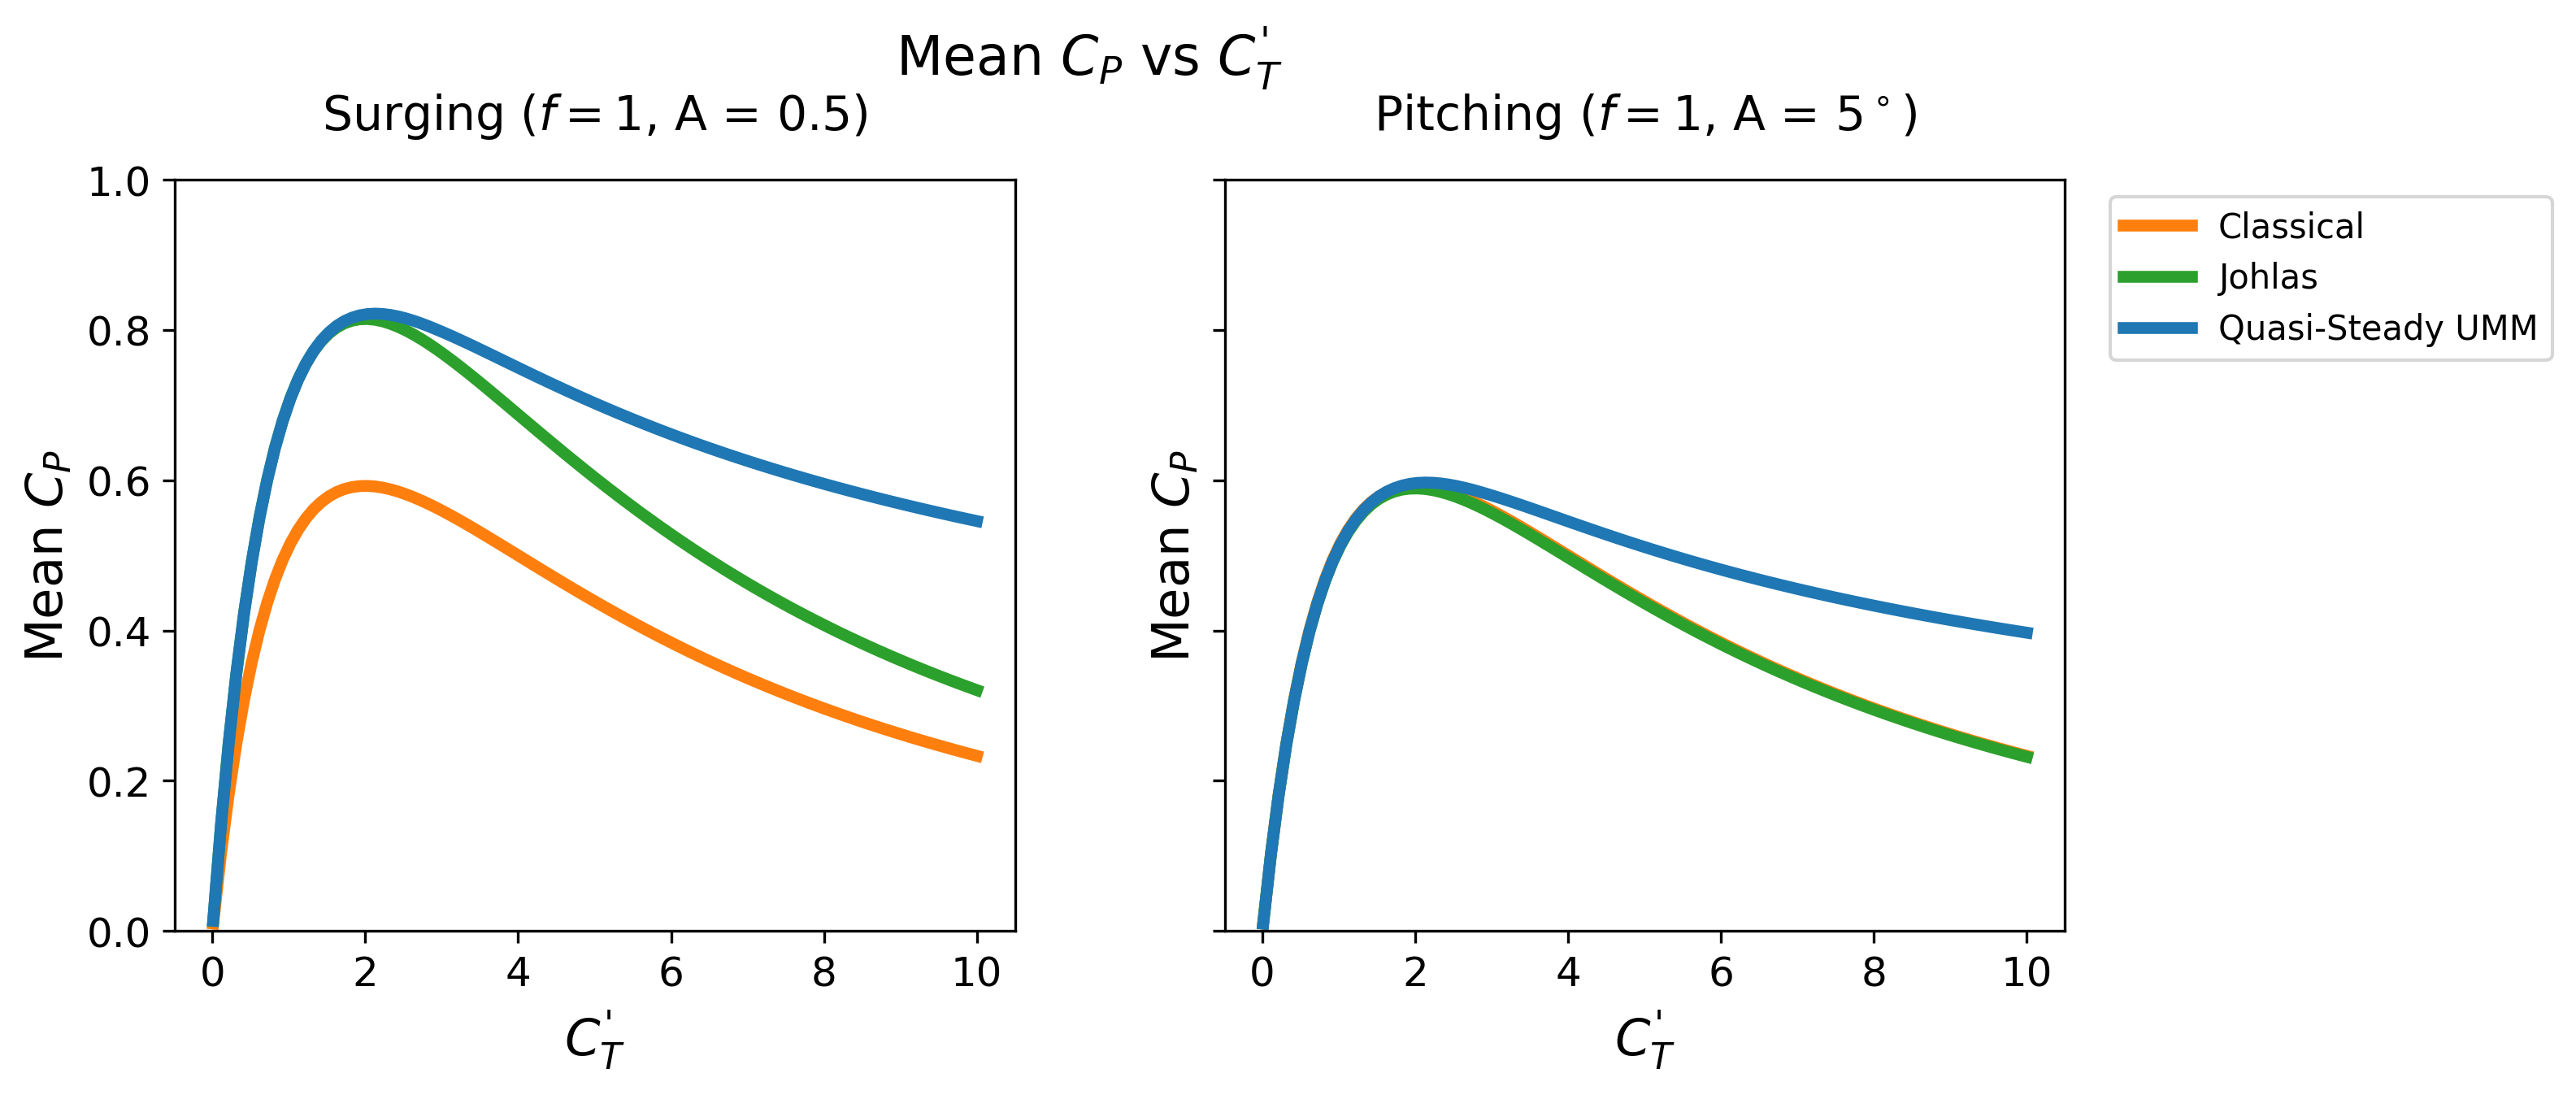

In [1492]:
f, sa, pa = 1, 0.5, 5
plot_mean_cp_models(ctp_list, f, sa, pa);

# Analyze LES Data

In [1493]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/expanded_moving_analysis_july_27_25.csv")
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df['rounded_dt'] = df.apply(lambda row: round(row["dt"], ndigits = 3), axis = 1)
df = df[df.nx >= 256]  # only keep 256 x 128 x 128 simulations
df = df[df.filterFactor >= 1.5]
df = df[df.useCorrection]
df = df[df.turbulence == False]

In [1494]:
df_f1_a5_surge = df[(df.marker == 's') & (df.surge_amplitude == 0.5) & ((df.nx == 256) |( df.nx == 512)) & (df.CT_prime == 4) & (df.filterFactor > 1.1)]
df_f1_a5_surge = df_f1_a5_surge.sort_values(by = ["CT_prime", "nx", "filterFactor", "dt", "surge_freq", "surge_amplitude"])
df_f1_a5_surge[["CT_prime", "nx", "ny", "dt", "filterFactor", "filter", "surge_amplitude", "surge_freq", "mean_Cp"]]

,CT_prime,nx,ny,dt,filterFactor,filter,surge_amplitude,surge_freq,mean_Cp
155,4.0,256.0,128.0,0.062500,1.5,0.221187,0.5,0.1,0.765729
158,4.0,256.0,128.0,0.062500,1.5,0.221187,0.5,0.5,0.836258
95,4.0,256.0,128.0,0.062500,1.5,0.221187,0.5,1.0,0.848317
206,4.0,256.0,128.0,0.062500,2.5,0.368644,0.5,0.1,0.746993
207,4.0,256.0,128.0,0.062500,2.5,0.368644,0.5,0.5,0.827030
109,4.0,256.0,128.0,0.062500,2.5,0.368644,0.5,1.0,0.814068
208,4.0,256.0,128.0,0.062500,2.5,0.368644,0.5,1.0,0.803210
218,4.0,256.0,128.0,0.062500,3.5,0.516102,0.5,0.1,0.734771
219,4.0,256.0,128.0,0.062500,3.5,0.516102,0.5,0.5,0.793583
220,4.0,256.0,128.0,0.062500,3.5,0.516102,0.5,1.0,0.790051


In [1495]:
df_nans = df[df.isna().any(axis=1)]
df_nans_ct4_surge5 = df_nans[(df_nans.marker == 's') & (df_nans.surge_amplitude == 0.5)]
df_nans_ct4_surge5 = df_nans_ct4_surge5.sort_values(by = ["CT_prime", "filterFactor", "dt", "surge_freq"])
df_nans_ct4_surge5[["CT_prime", "dt", "nx", "ny", "filterFactor", "filter", "surge_freq"]]

,CT_prime,dt,nx,ny,filterFactor,filter,surge_freq
239,4.0,0.024414,512.0,256.0,1.5,0.110593,0.1
236,4.0,0.048828,512.0,256.0,1.5,0.110593,0.1
237,4.0,0.048828,512.0,256.0,1.5,0.110593,0.5
227,4.0,0.048828,512.0,256.0,2.5,0.184322,0.1
228,4.0,0.048828,512.0,256.0,2.5,0.184322,0.5
234,4.0,0.048828,512.0,256.0,3.5,0.258051,0.1
235,4.0,0.048828,512.0,256.0,3.5,0.258051,0.5


In [1496]:
df_nans[["CT_prime", "dt", "nx", "ny", "filterFactor", "filter", "surge_freq", "surge_amplitude", "pitch_amplitude"]]

,CT_prime,dt,nx,ny,filterFactor,filter,surge_freq,surge_amplitude,pitch_amplitude
169,4.0,0.062500,256.0,128.0,1.5,0.221187,0.1,1.0,0.0
170,4.0,0.062500,256.0,128.0,1.5,0.221187,0.5,1.0,0.0
171,4.0,0.062500,256.0,128.0,1.5,0.221187,1.0,1.0,0.0
209,4.0,0.062500,256.0,128.0,1.5,0.221187,1.0,1.0,0.0
210,4.0,0.062500,256.0,128.0,2.5,0.368644,1.0,1.0,0.0
211,4.0,0.041667,256.0,128.0,1.5,0.221187,1.5,1.0,0.0
212,4.0,0.041667,256.0,128.0,2.5,0.368644,1.5,1.0,0.0
221,4.0,0.062500,256.0,128.0,3.5,0.516102,1.0,1.0,0.0
227,4.0,0.048828,512.0,256.0,2.5,0.184322,0.1,0.5,0.0
228,4.0,0.048828,512.0,256.0,2.5,0.184322,0.5,0.5,0.0


In [1497]:
df = df.dropna()
df

,Unnamed: 0,marker,dt,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,...,std_an,std_Cp,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp,Movement,rounded_dt
91,91,o,0.097656,256.0,128.0,0.221187,1.5,True,1.0,False,...,1.104504e-11,2.258713e-11,1.205347,-1.205355,1.126981,9.766238,9.766252,8.531289,Stationary,0.098
92,92,s,0.062500,256.0,128.0,0.221187,1.5,True,1.0,False,...,3.404967e-01,7.073992e-01,0.307302,0.007350,0.553753,-1.439070,-1.502191,-1.244002,Surging,0.062
93,93,^,0.062500,256.0,128.0,0.221187,1.5,True,1.0,False,...,1.530881e-03,2.957230e-03,-0.005360,0.006808,-0.003913,-1.494225,-1.494181,-1.494265,Pitching,0.062
94,94,o,0.097656,256.0,128.0,0.221187,1.5,True,4.0,False,...,1.397783e-04,4.499452e-04,-0.509006,0.509348,-0.508665,-0.897387,-0.896846,-0.897927,Stationary,0.098
95,95,s,0.062500,256.0,128.0,0.221187,1.5,True,4.0,False,...,3.106101e-01,9.652361e-01,0.469569,0.010257,0.747997,-1.353052,-1.505538,-1.020106,Surging,0.062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,232,^,0.048828,512.0,256.0,0.258051,3.5,True,4.0,False,...,4.109174e-04,1.327209e-03,-0.001648,0.002244,-0.001052,-1.498195,-1.498192,-1.498197,Pitching,0.049
233,233,^,0.048828,512.0,256.0,0.258051,3.5,True,4.0,False,...,5.154306e-04,1.642429e-03,-0.001131,0.001888,-0.000375,-1.495891,-1.495889,-1.495892,Pitching,0.049
238,238,s,0.048828,512.0,256.0,0.110593,1.5,True,4.0,False,...,3.118363e-01,9.638750e-01,0.452774,0.028963,0.729542,-1.371995,-1.505773,-1.051380,Surging,0.049
240,240,s,0.024414,512.0,256.0,0.110593,1.5,True,4.0,False,...,2.735745e-01,8.455505e-01,0.360944,0.063946,0.636293,-1.426597,-1.494023,-1.167139,Surging,0.024


In [1498]:
df = df.dropna()
cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

In [1499]:
max_motion_df = df[df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

## Plot Mean $C_P$ LES Data for $f = 1$, $A_s = 0.5$, and $A_p = 5^\circ$ over $C_T'$ Values

/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value encountered in divide
  sin_a = np.where(tilt == 0, 0, -(np.sin(tilt) * np.cos(yaw)) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:51: RuntimeWarning: invalid value encountered in divide
  cos_a = np.where(tilt == 0, 1, np.sin(yaw) / np.sin(eff_yaw))
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/Geometry.py:52: RuntimeWarning: invalid value 

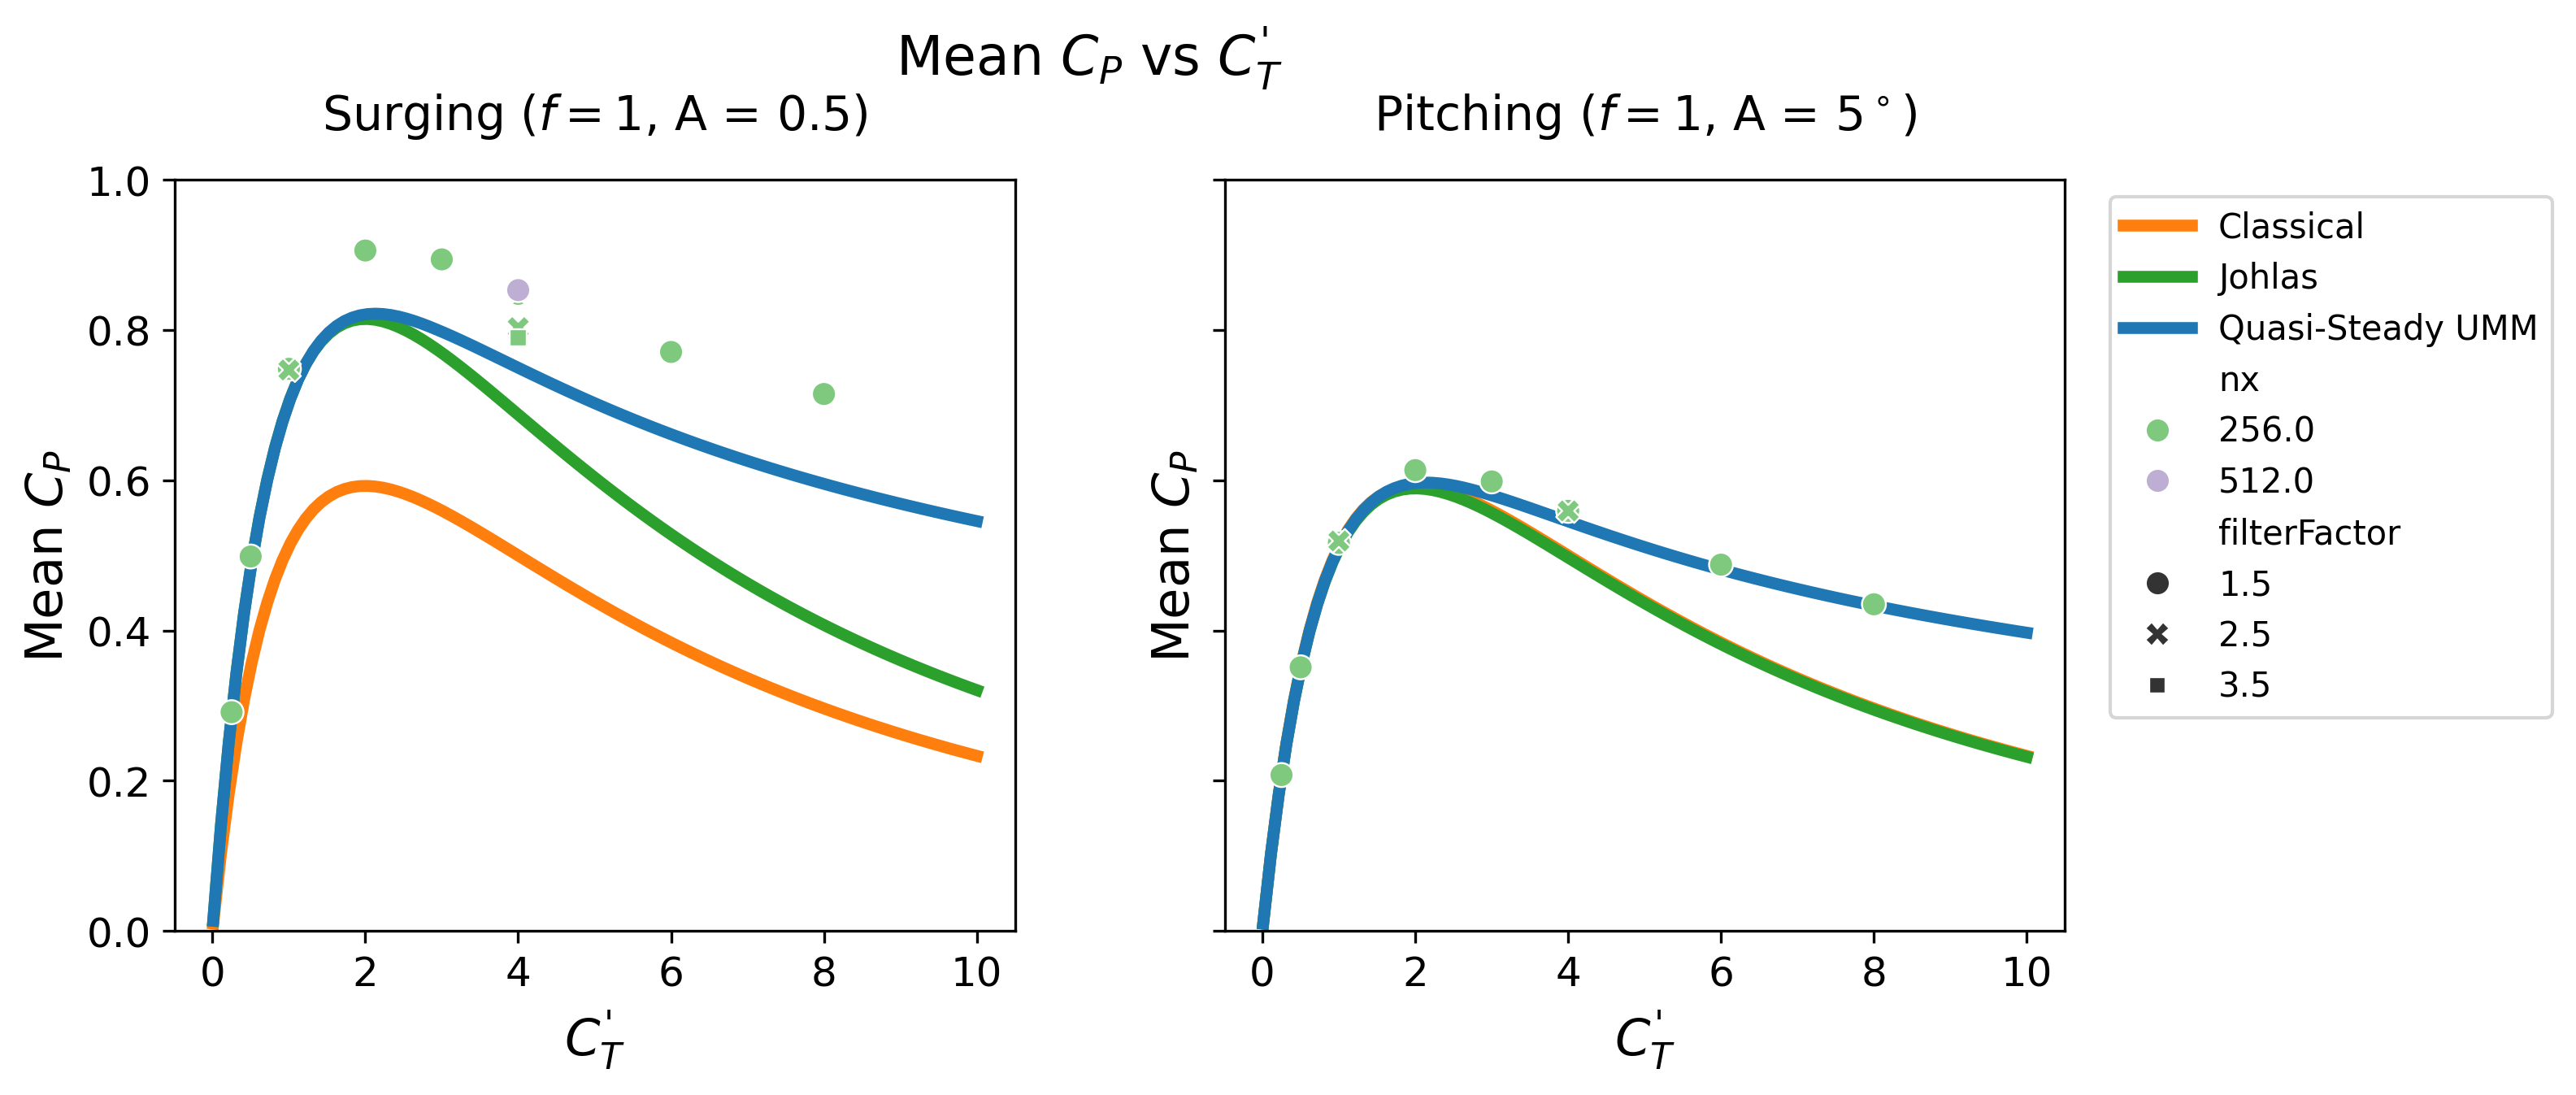

In [1500]:
fig, (ax0, ax1) = plot_mean_cp_models(ctp_list, f, sa, pa);
surging_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Surging"]
sns.scatterplot(ax  = ax0, data = surging_max_motion_df, x = "CT_prime", y = "mean_Cp", hue = "nx", style = "filterFactor", palette = "Accent", zorder = 5, s=50)
pitching_max_motion_df = max_motion_df[max_motion_df["Movement"] == "Pitching"]
sns.scatterplot(ax = ax1, data = pitching_max_motion_df, x = "CT_prime", y = "mean_Cp", hue = "nx", style = "filterFactor", palette = "Accent", zorder = 5, s=50, legend = False)
fix_plot_legend(ax0)

## Calculate Differences Between UMM and LES

In [1501]:
df["umm"] = df.apply((lambda row: umm(row.CT_prime, row.surge_freq, row.surge_amplitude, row.pitch_amplitude)[0]), axis = 1)
df["percent_diff_umm"] = df.apply((lambda row: 100 * (row.umm - row.mean_Cp) / row.mean_Cp), axis = 1)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/3318810174.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/3318810174.py:4: RuntimeWarning: invalid value encountered in scalar multiply
  sin_vals = np.array([np.sin(sf_rad * x) for x in np.linspace(0, 2 * np.pi / sf_rad, 250)])
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt3Y-py3.11/lib/python3.11/site-packages/UnifiedMomentumModel/Utilities/FixedPointIteration.py:56: RuntimeWarning: All-NaN slice encountered
  max_resid = [np.nanmax(np.abs(_r)) for _r in residuals]
/Users/sky/Library/Caches/pypoetry/virtualenvs/simspadeops-Wg-7Zt

In [1502]:
def plot_umm_les(df, ctp, mask = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
    fig.suptitle(f"Mean $C_P$ vs Amplitude for Varying Frequencies for $C_T' = {ctp}$", size = 16, y = 1.04)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel('Mean $C_P$', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    ax0_data = df[(df["Movement"] == "Surging") & (df["CT_prime"] == ctp)]
    ax1_data = df[(df["Movement"] == "Pitching") & (df["CT_prime"] == ctp)]
    if mask is not None:
        ax0_data = ax0_data[mask]
        ax1_data = ax1_data[mask]
    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
    sns.lineplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "umm", color = "k", label = "UMM")

    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)
    sns.lineplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "umm", color = "k")

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    fig.subplots_adjust(hspace = 0.5)


In [1503]:
def plot_umm_error(df, ctp, mask = None):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey = True, figsize = (8, 3), dpi = 300)
    fig.suptitle(f"UMM Error vs Amplitude for Varying Frequencies for $C_T' = {ctp}$", size = 16, y = 1.04)
    ax0.set_title("Surging", size = 14)
    ax1.set_title("Pitching", size = 14)
    ax0.set_xlabel('Amplitude [-]', size = 12)
    ax1.set_xlabel('Amplitude [$^\circ$]', size = 12)
    ax0.set_ylabel('UMM $C_P$ Error [%]', size = 12)
    ax1.set_ylabel(' ', size = 12)
    ax0.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)

    surge_mask = (df["Movement"] == "Surging") & (df["CT_prime"] == ctp)
    pitch_mask = (df["Movement"] == "Pitching") & (df["CT_prime"] == ctp)
    if mask is not None:
        surge_mask = surge_mask & mask
        pitch_mask = pitch_mask & mask
    ax0_data = df[surge_mask]
    ax1_data = df[pitch_mask]

    sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
    sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)

    fix_plot_legend(ax0, xOffset = 1.7, title = "Frequency")
    fig.subplots_adjust(hspace = 0.5)


## Plot Mean $C_P$ from UMM for $C_T' = 1$ for a range of $f$ and $A$

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax0_data = ax0_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = ax1_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", p

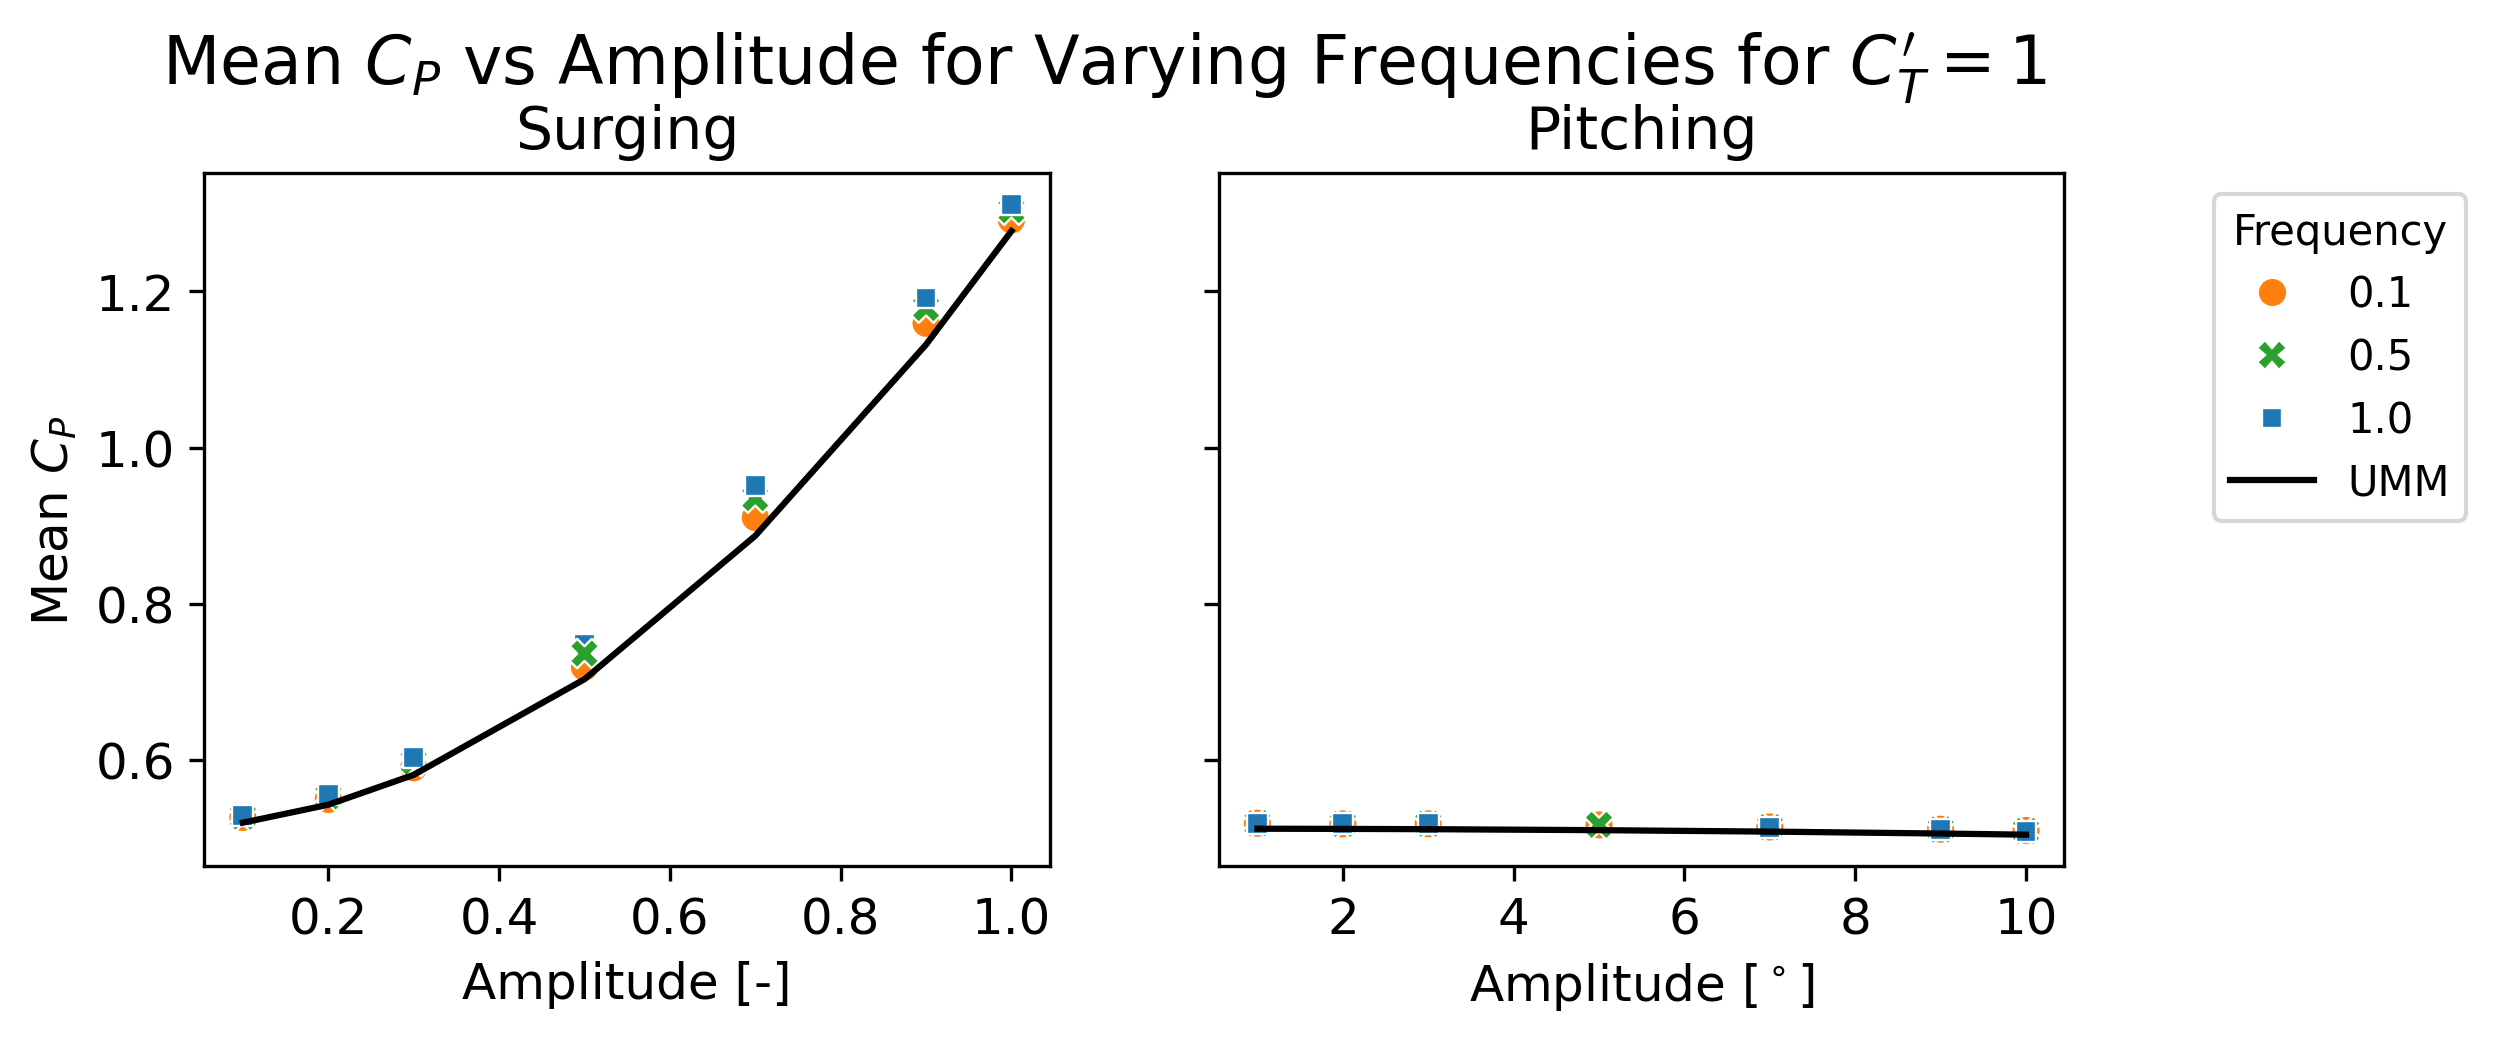

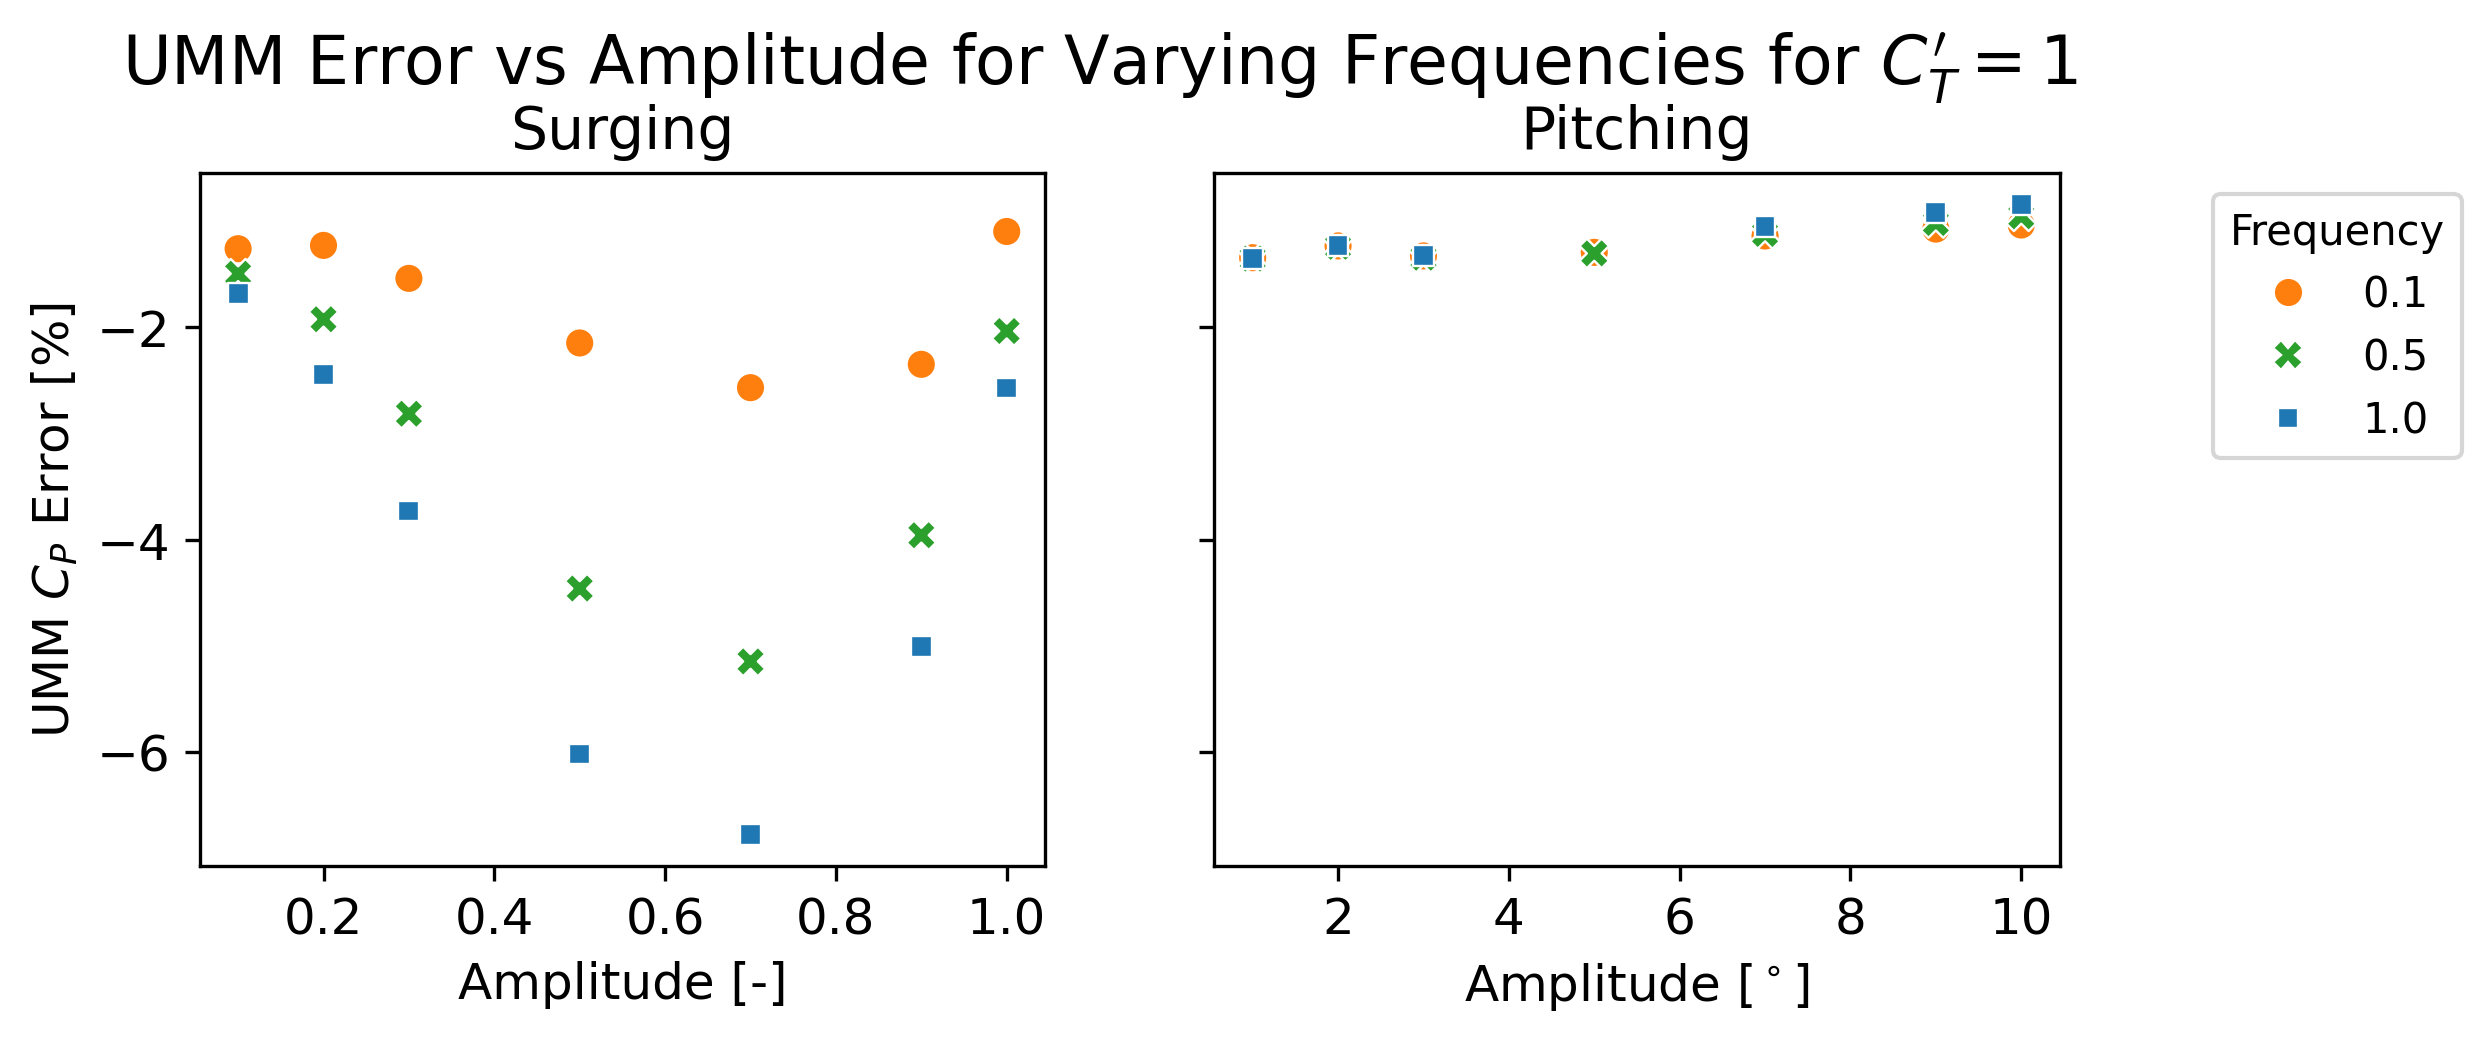

In [1504]:
ctp = 1
mask = (df.filterFactor == 1.5) & (df.nx == 256) & (df.surge_freq < 1.5)
plot_umm_les(df, ctp, mask = mask)
plot_umm_error(df, ctp, mask = mask)

## Plot Mean $C_P$ from UMM for $C_T' = 2$ for a range of $f$ and $A$

In [1505]:
df[df.CT_prime == 2]

,Unnamed: 0,marker,dt,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,...,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp,Movement,rounded_dt,umm,percent_diff_umm
118,118,s,0.0625,256.0,128.0,0.221187,1.5,True,2.0,False,...,0.360949,0.010516,0.626217,-1.416732,-1.503832,-1.170981,Surging,0.062,0.821002,-9.376682
119,119,^,0.0625,256.0,128.0,0.221187,1.5,True,2.0,False,...,-0.016089,0.017929,-0.014250,-1.483688,-1.483533,-1.483837,Pitching,0.062,0.596299,-2.815336


/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50, legend = False)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1883978649.py:21: UserWarning: The palette list has more values (5) than needed (1), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "percent_diff_umm", hue = "surge_freq", style = "surge_freq", palette = palette, s=5

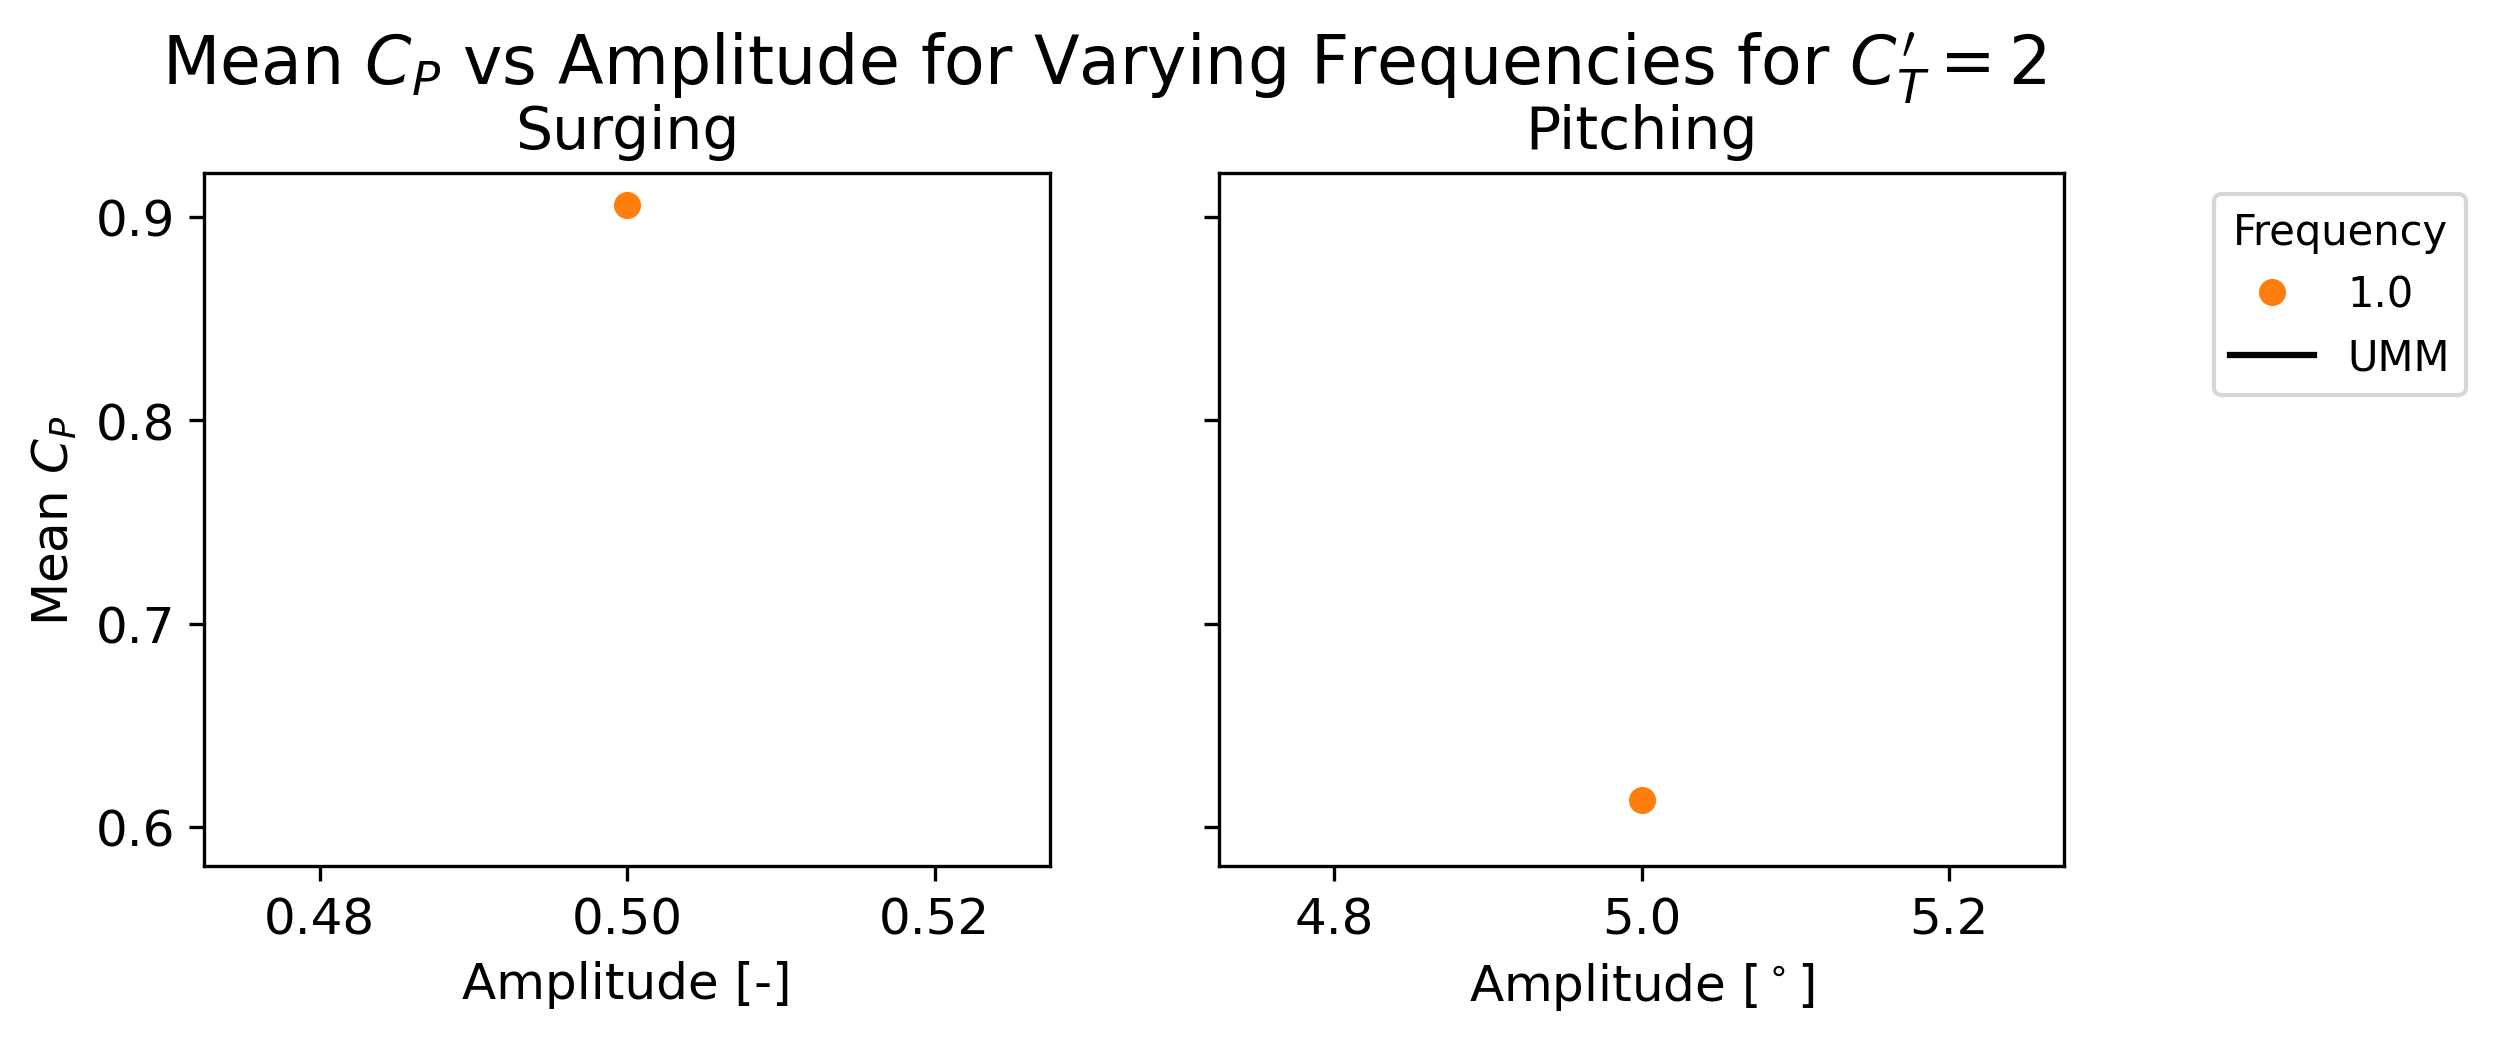

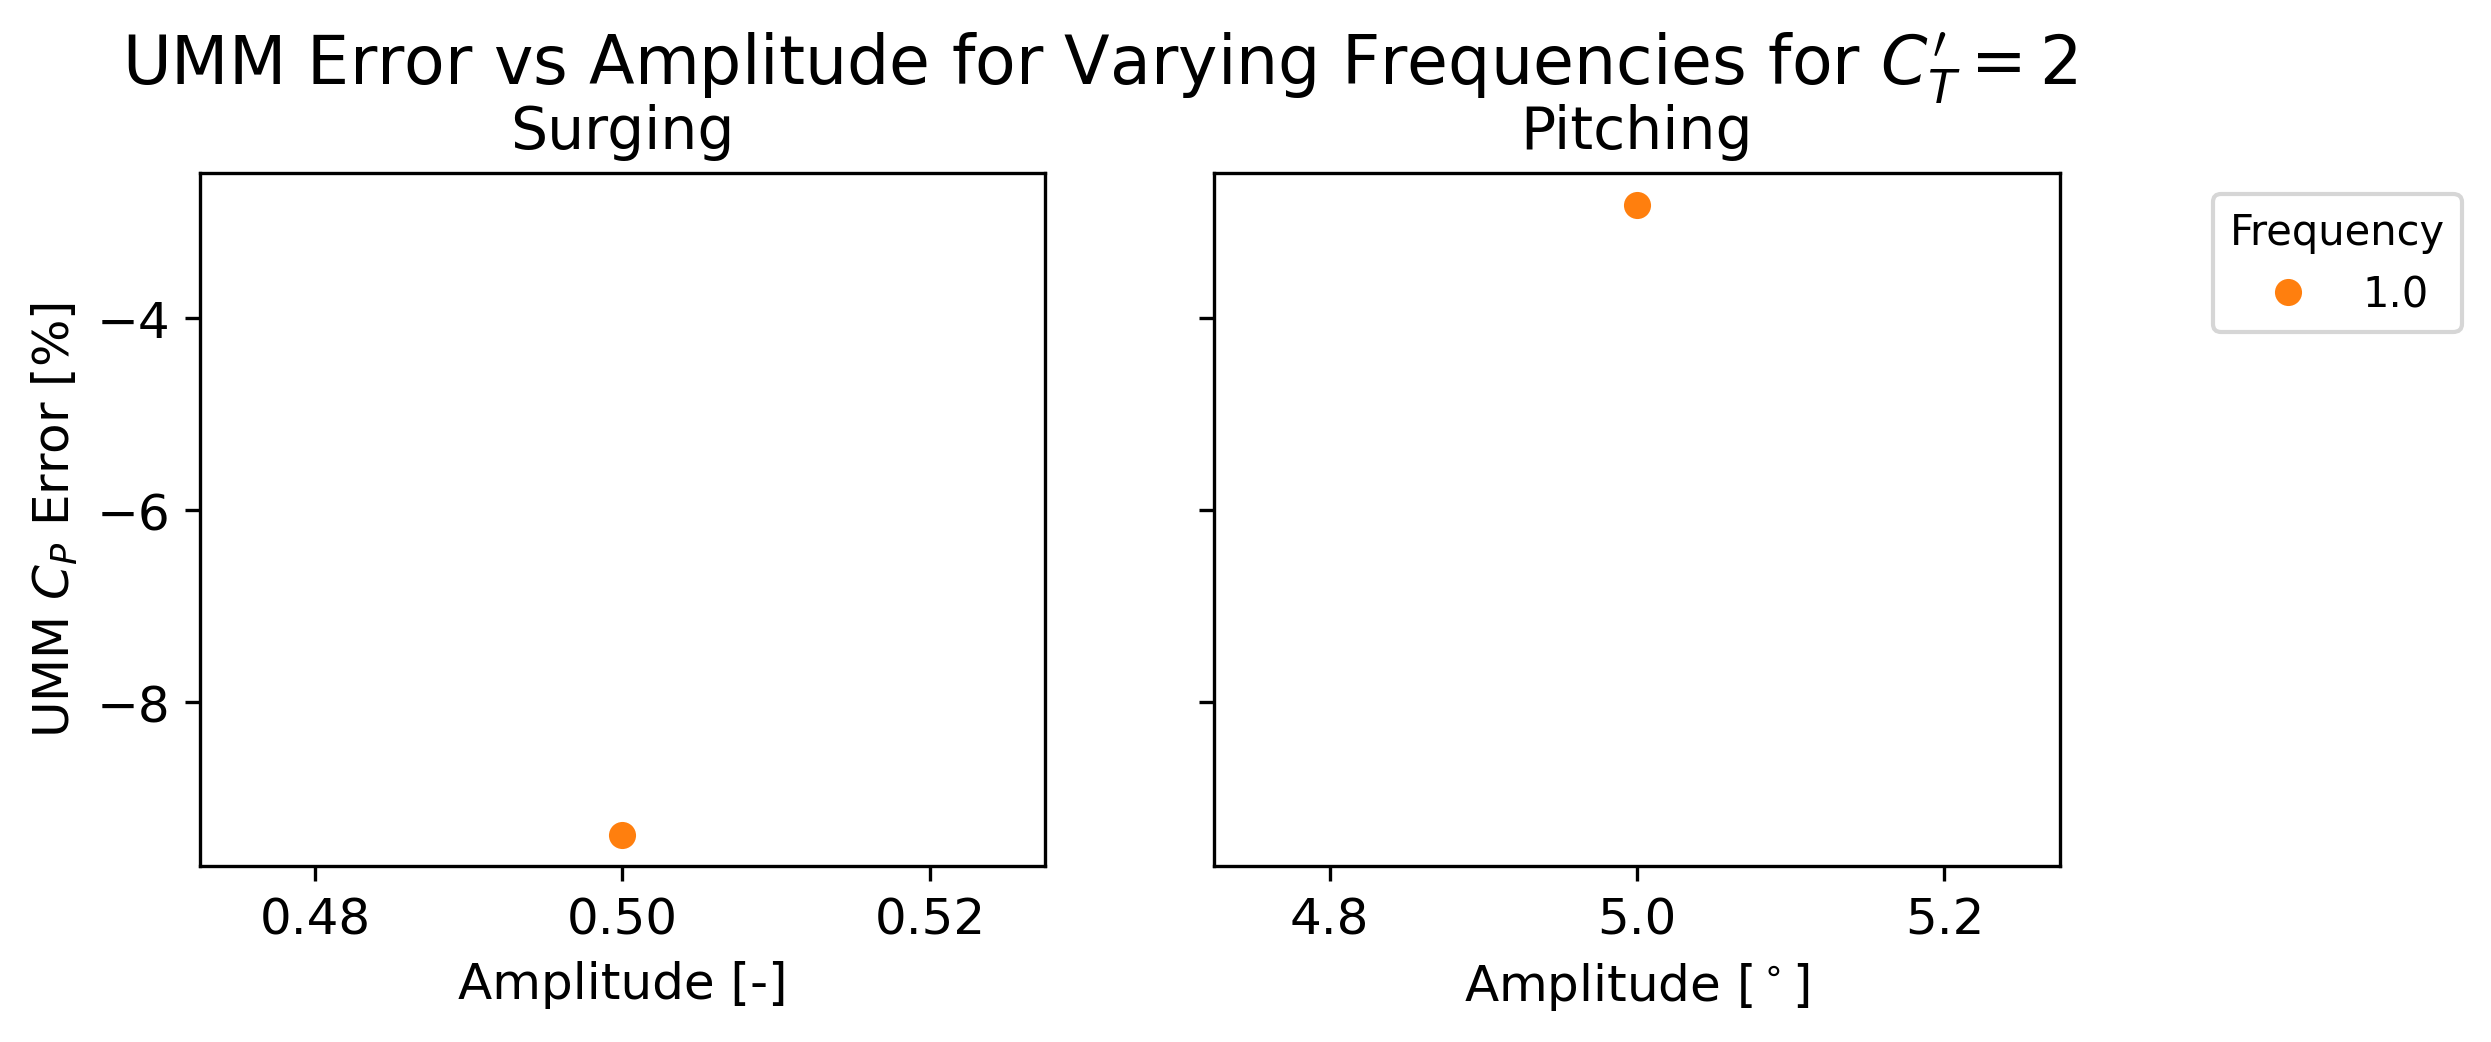

In [1506]:
ctp = 2
plot_umm_les(df, ctp)
plot_umm_error(df, ctp)

## Plot Mean $C_P$ from UMM for $C_T' = 4$ for a range of $f$ and $A$

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax0_data = ax0_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax1_data = ax1_data[mask]
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:18: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, s=50)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_1740/1712811092.py:21: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(ax = ax1, data = ax1_data, x = "pitch_amplitude", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", p

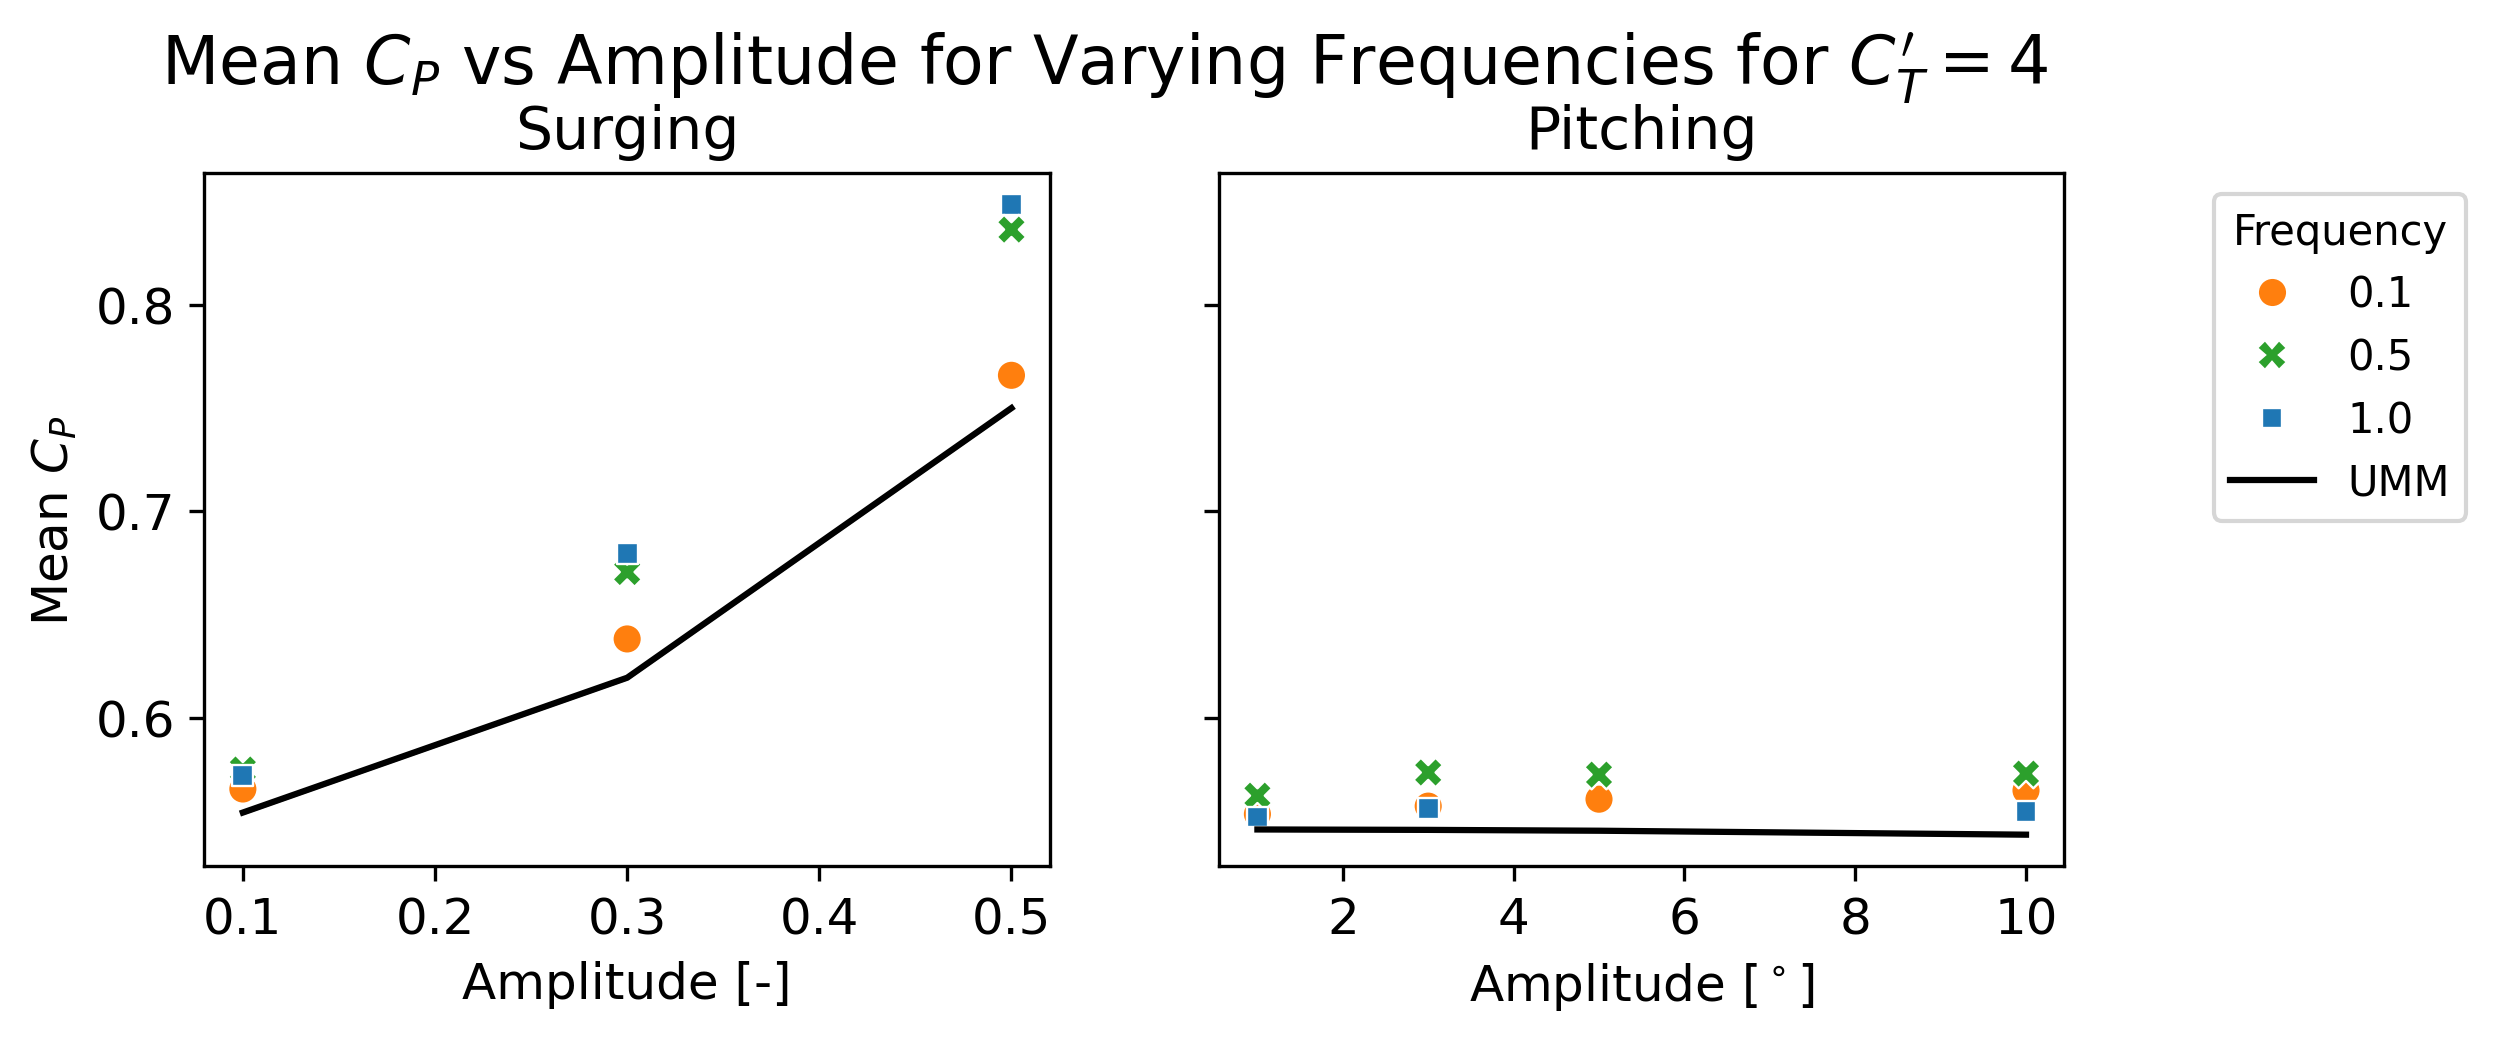

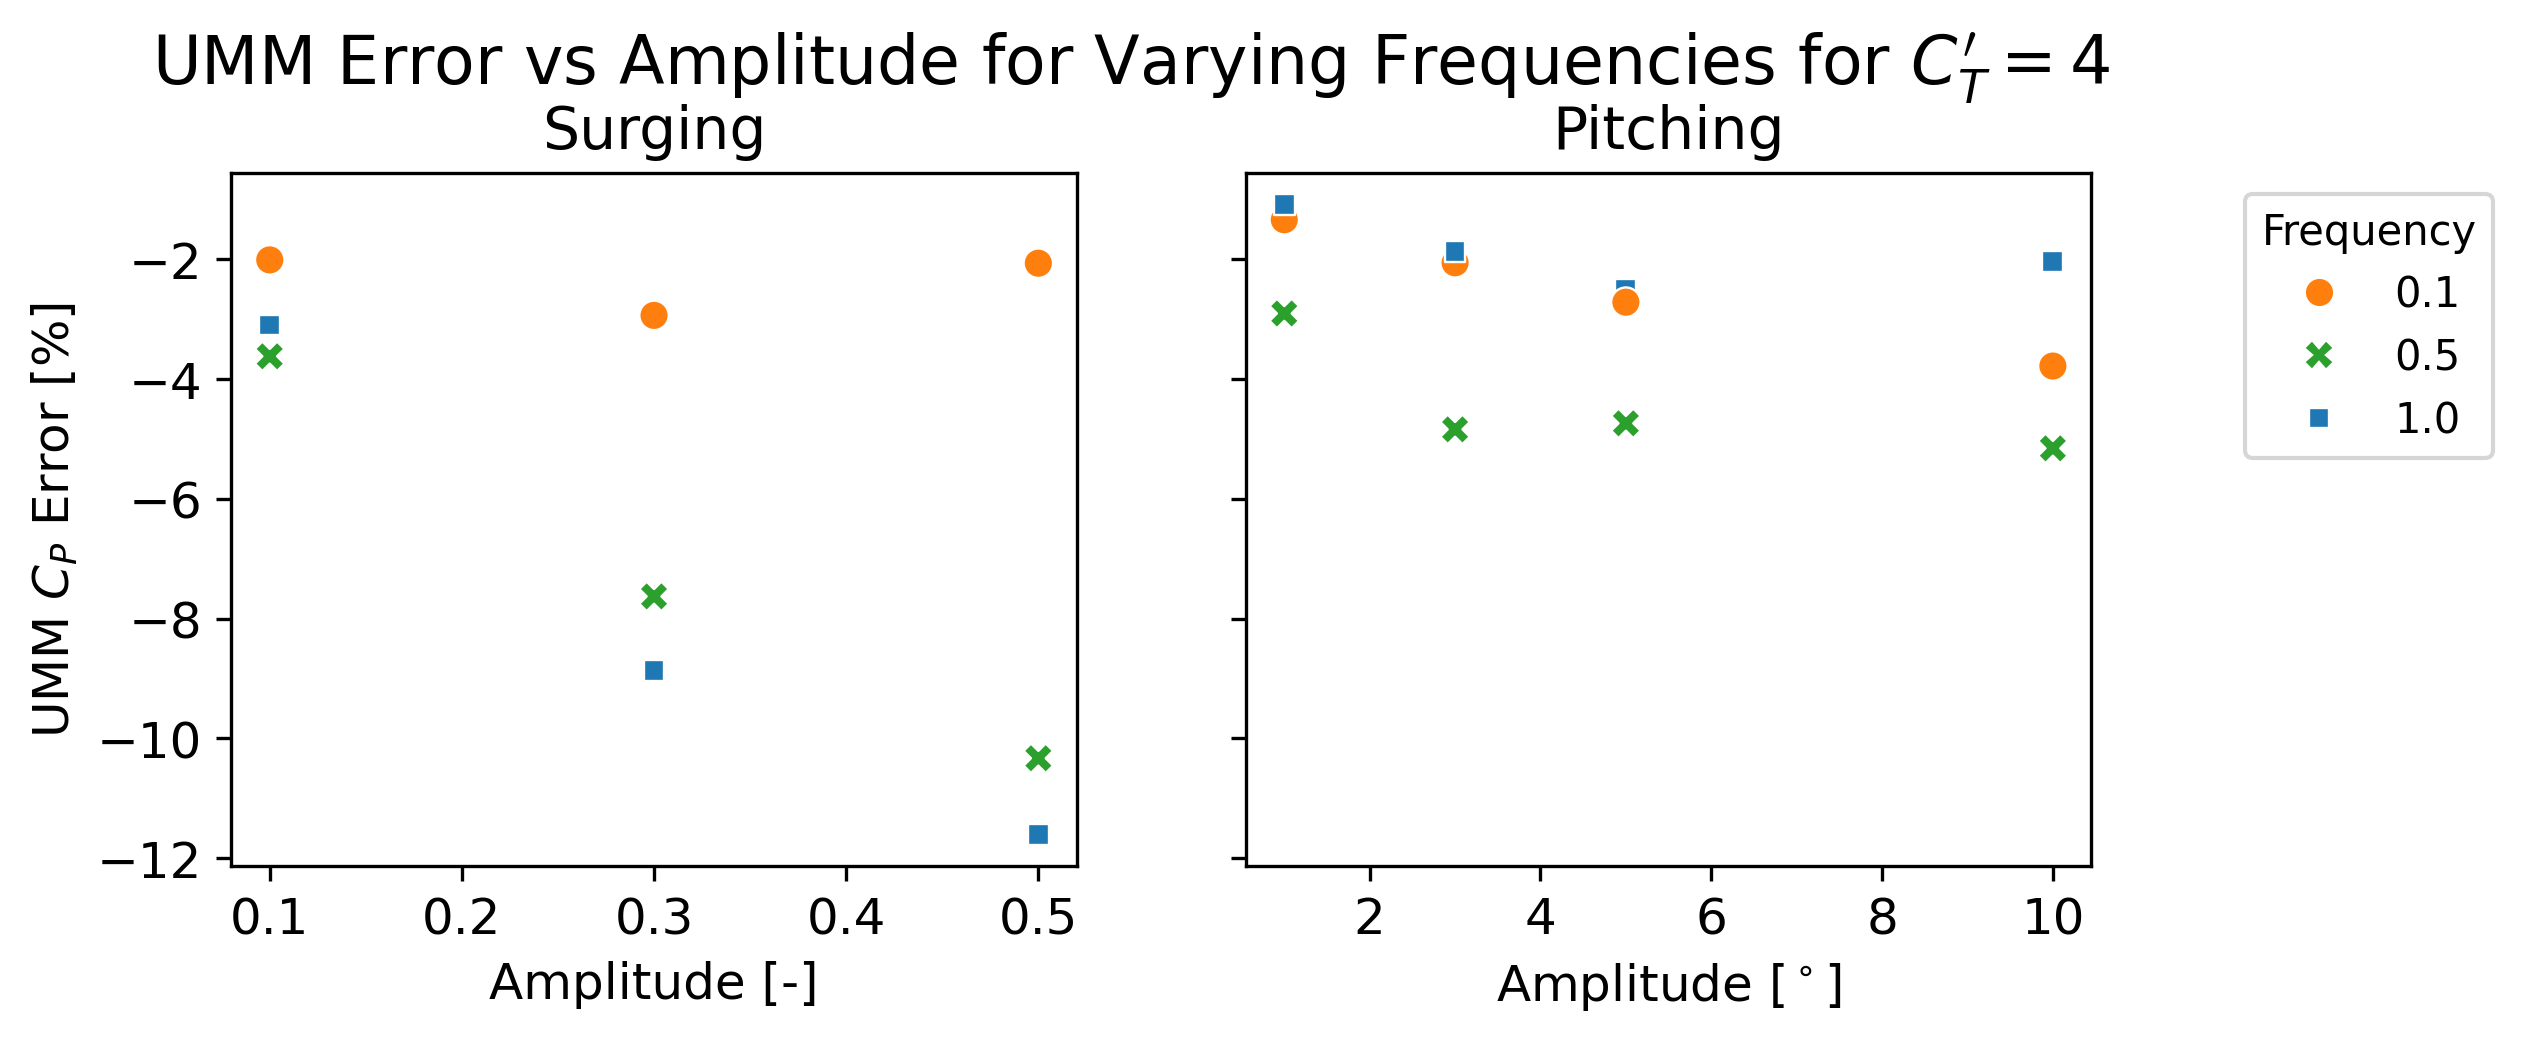

In [1507]:
ctp = 4
mask = (df.filterFactor == 1.5) & (df.nx == 256) & (df.surge_freq < 1.5)
plot_umm_les(df, ctp, mask)
plot_umm_error(df, ctp, mask)

In [1508]:
df[(df.surge_amplitude == 0.5)]

,Unnamed: 0,marker,dt,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,...,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp,Movement,rounded_dt,umm,percent_diff_umm
92,92,s,0.062500,256.0,128.0,0.221187,1.5,True,1.00,False,...,0.307302,0.007350,0.553753,-1.439070,-1.502191,-1.244002,Surging,0.062,0.703407,-6.017250
95,95,s,0.062500,256.0,128.0,0.221187,1.5,True,4.00,False,...,0.469569,0.010257,0.747997,-1.353052,-1.505538,-1.020106,Surging,0.062,0.749871,-11.604823
106,106,s,0.062500,256.0,128.0,0.368644,2.5,True,1.00,False,...,0.306762,0.002246,0.550761,-1.438295,-1.502045,-1.246364,Surging,0.062,0.703407,-5.818760
118,118,s,0.062500,256.0,128.0,0.221187,1.5,True,2.00,False,...,0.360949,0.010516,0.626217,-1.416732,-1.503832,-1.170981,Surging,0.062,0.821002,-9.376682
120,120,s,0.062500,256.0,128.0,0.221187,1.5,True,3.00,False,...,0.417220,0.011056,0.692876,-1.386789,-1.504894,-1.092795,Surging,0.062,0.797865,-10.767130
122,122,s,0.062500,256.0,128.0,0.221187,1.5,True,0.25,False,...,0.270064,0.002708,0.496698,-1.452059,-1.501252,-1.294508,Surging,0.062,0.286275,-1.741996
124,124,s,0.062500,256.0,128.0,0.221187,1.5,True,0.50,False,...,0.282288,0.004499,0.516117,-1.447977,-1.501515,-1.277955,Surging,0.062,0.482340,-3.258792
126,126,s,0.062500,256.0,128.0,0.221187,1.5,True,6.00,False,...,0.549694,0.007430,0.822484,-1.288920,-1.505843,-0.908845,Surging,0.062,0.661350,-14.210227
128,128,s,0.062500,256.0,128.0,0.221187,1.5,True,8.00,False,...,0.604106,0.004941,0.867598,-1.235804,-1.505720,-0.834234,Surging,0.062,0.595308,-16.733139
132,132,s,0.062500,256.0,128.0,0.221187,1.5,True,1.00,False,...,0.269433,0.007179,0.498285,-1.451476,-1.499721,-1.292522,Surging,0.062,0.703407,-2.148024


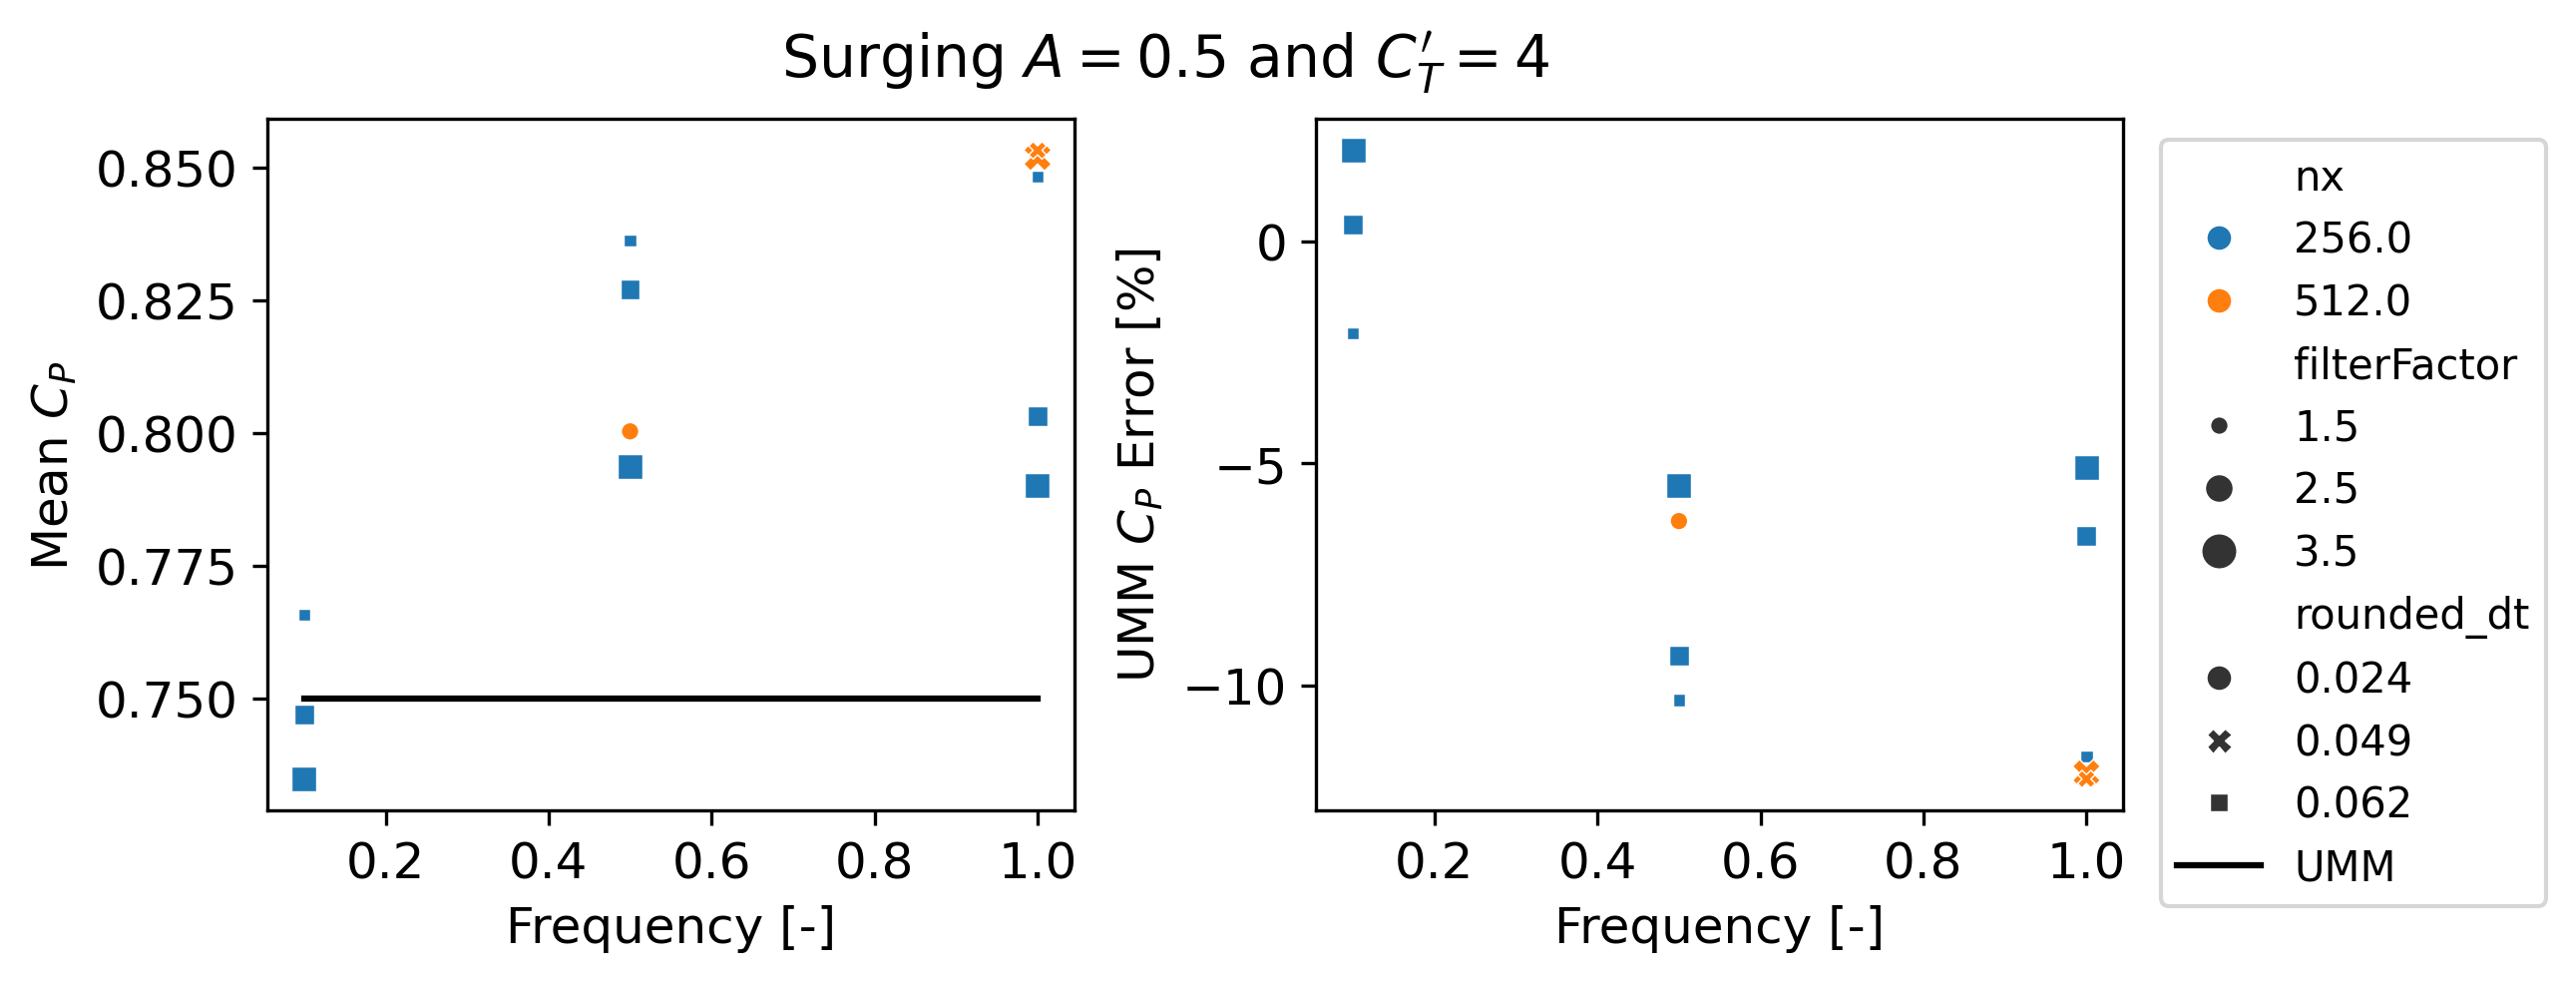

In [1516]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Surging $A = 0.5$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.surge_amplitude == 0.5) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)


In [1510]:
ax0_data = ax0_data.sort_values(by = ["nx", "filterFactor", "dt", "surge_freq", "surge_amplitude"])
ax0_data[["nx","filterFactor", "filter", "dt", "surge_amplitude", "surge_freq", "mean_Cp"]]

,nx,filterFactor,filter,dt,surge_amplitude,surge_freq,mean_Cp


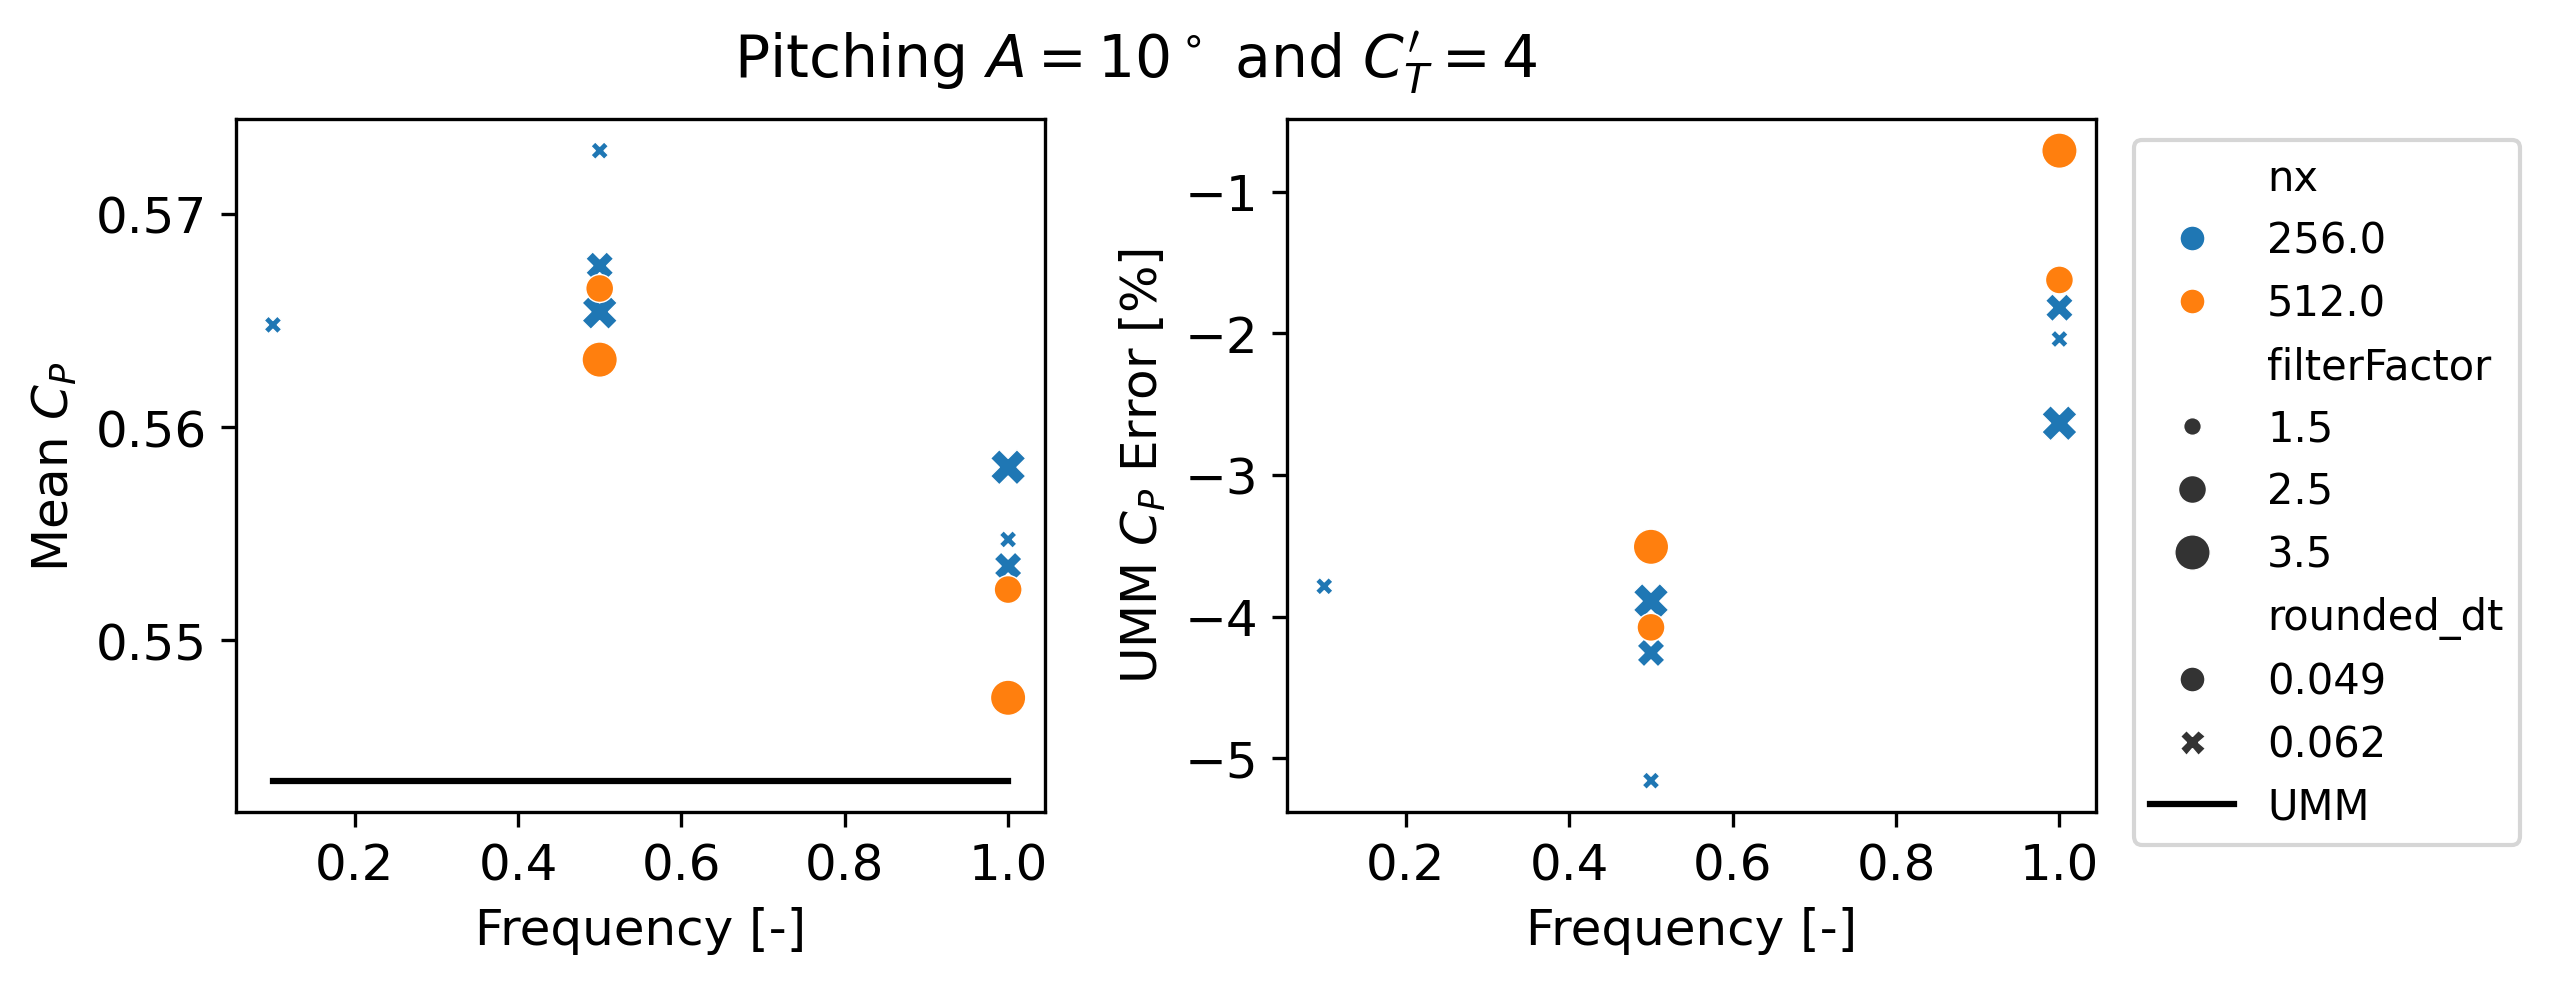

In [1511]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (8, 3), dpi = 300)
fig.suptitle("Pitching $A = 10^\circ$ and $C_T' = 4$", size = 14)
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('Mean $C_P$', size = 12)
ax0.tick_params(axis='both', which='major', labelsize=12)

ax1.set_xlabel('Frequency [-]', size = 12)
ax1.set_ylabel('UMM $C_P$ Error [%]', size = 12)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax0_data = df[(df.pitch_amplitude == 10) & (df.CT_prime == 4)]

sns.scatterplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "mean_Cp", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor")
sns.lineplot(ax = ax0, data = ax0_data, x = "surge_freq", y = "umm", color = "k", label = "UMM")

sns.scatterplot(ax = ax1, data = ax0_data, x = "surge_freq", y = "percent_diff_umm", hue = "nx", style = "rounded_dt", palette = "tab10", size = "filterFactor", legend = False)
fix_plot_legend(ax0)
fig.subplots_adjust(wspace=0.3)

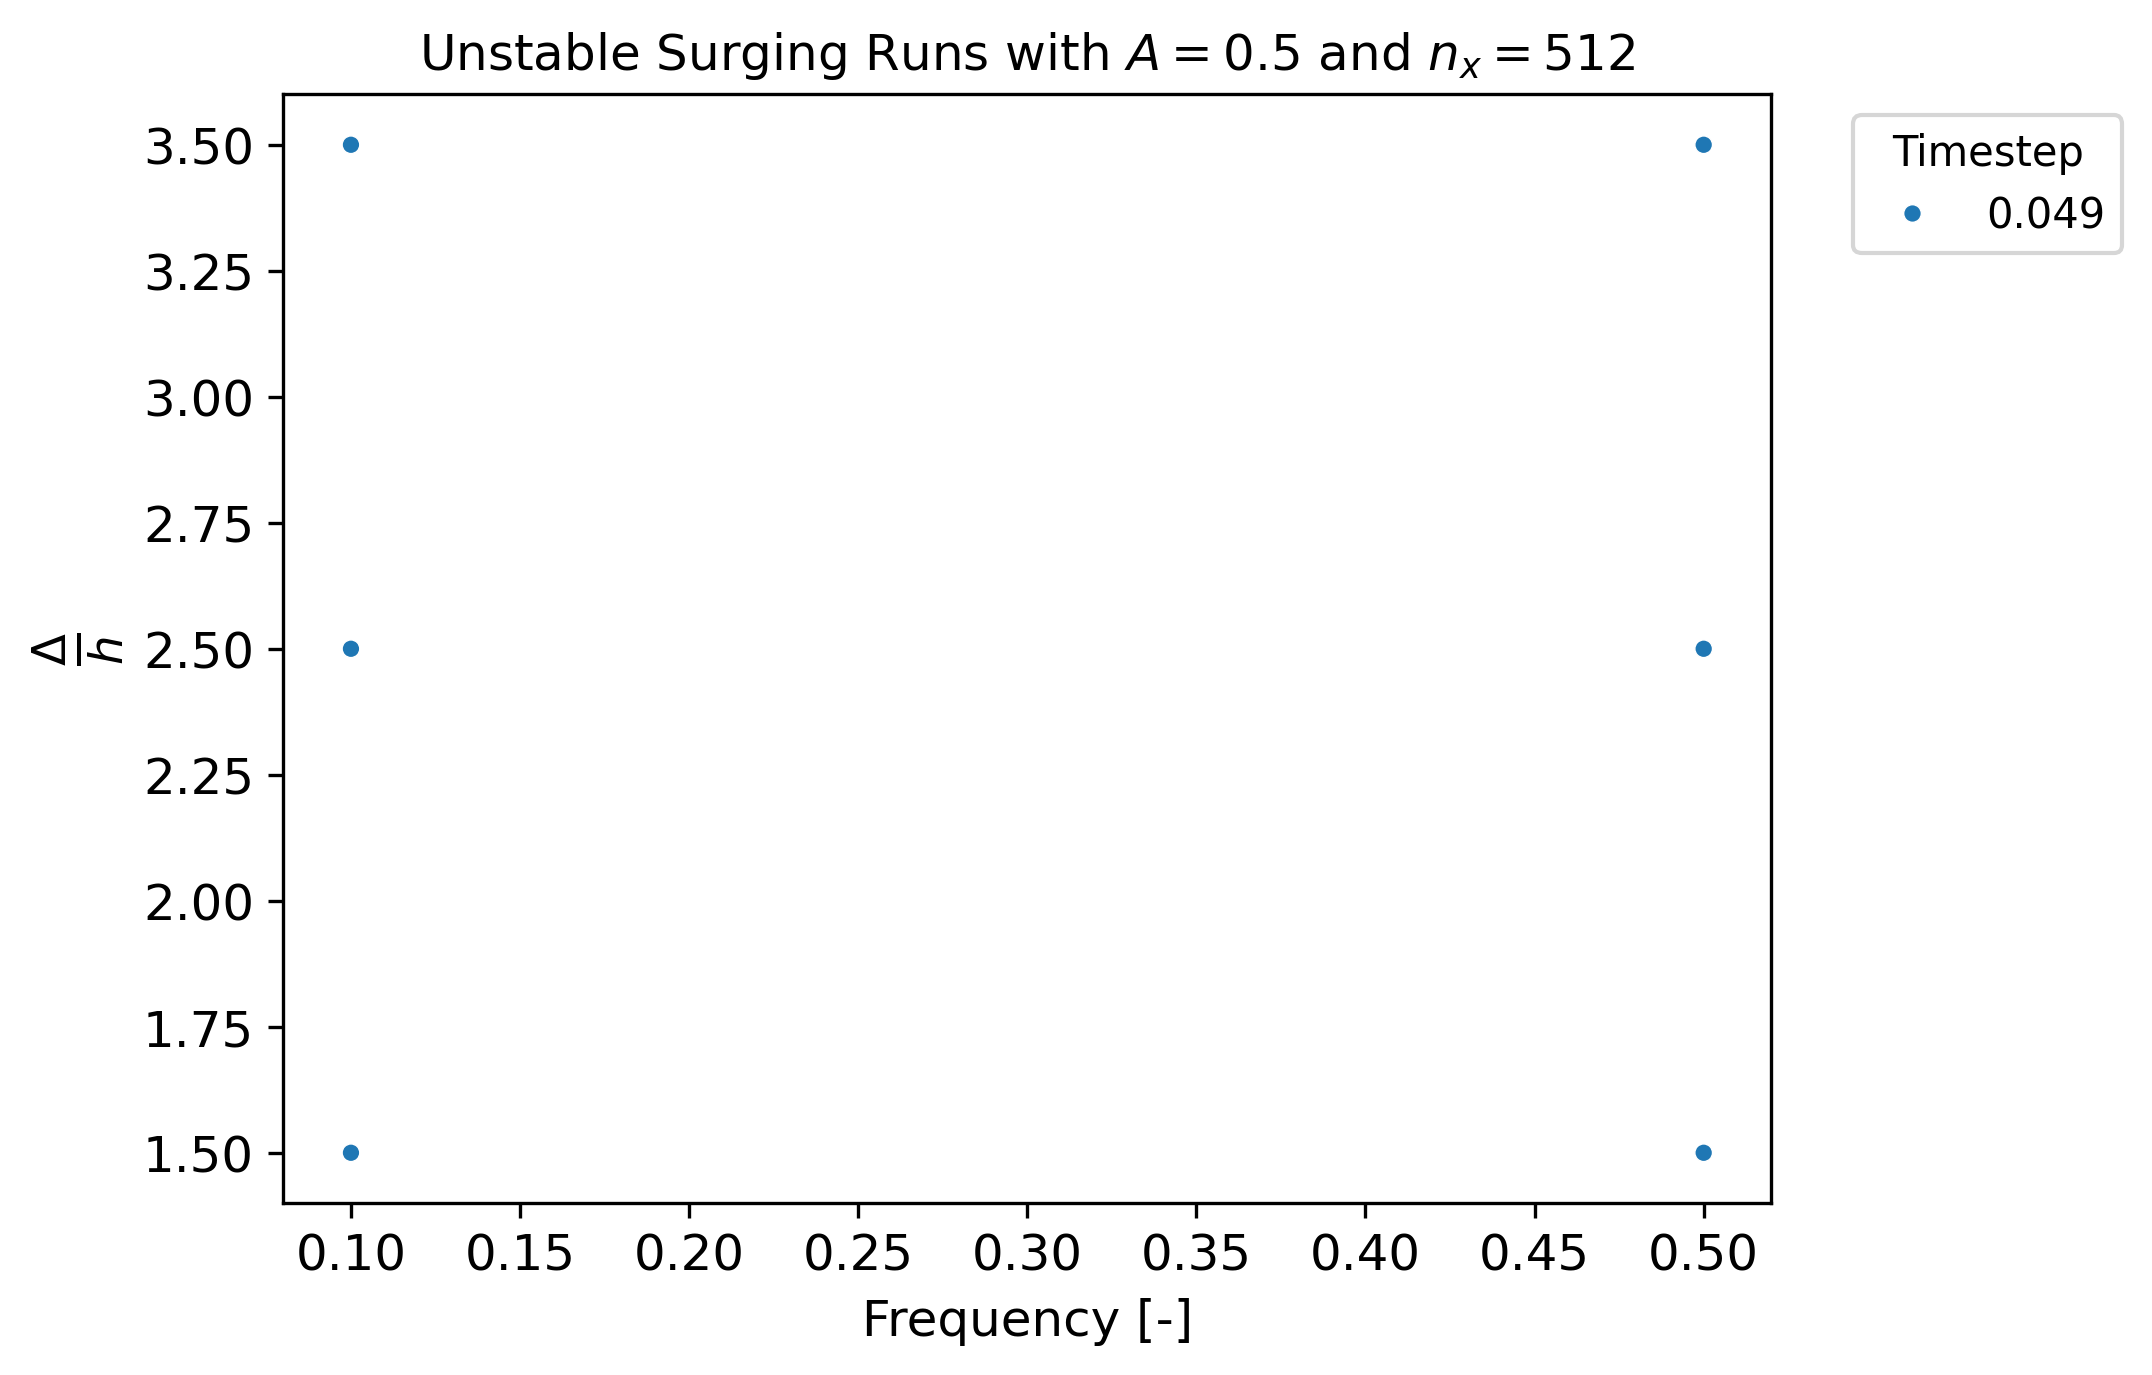

In [1515]:
fig, ax0 = plt.subplots(1, 1, dpi = 300)
ax0.set_title("Unstable Surging Runs with $A = 0.5$ and $n_x = 512$")
ax0.set_xlabel('Frequency [-]', size = 12)
ax0.set_ylabel('$\\frac{\Delta}{h}$', size = 16)
ax0.tick_params(axis='both', which='major', labelsize=12)

sns.scatterplot(ax = ax0, data = df_nans[(df_nans.surge_amplitude == 0.5) & (df_nans.dt > 0.03)], x = "surge_freq", y = "filterFactor", hue = "rounded_dt", style = "rounded_dt", palette = "tab10", size = "rounded_dt")
fix_plot_legend(ax0, xOffset = 0.25, title="Timestep")

In [1513]:
df_nans_surge = df_nans[df_nans.surge_amplitude == 0.5]
df_nans_surge = df_nans_surge.sort_values(by = ["nx", "filterFactor", "dt", "surge_freq", "surge_amplitude"])
df_nans_surge[["nx","filterFactor", "filter", "dt", "surge_amplitude", "surge_freq", "mean_Cp"]]

,nx,filterFactor,filter,dt,surge_amplitude,surge_freq,mean_Cp
239,512.0,1.5,0.110593,0.024414,0.5,0.1,NaN
236,512.0,1.5,0.110593,0.048828,0.5,0.1,NaN
237,512.0,1.5,0.110593,0.048828,0.5,0.5,NaN
227,512.0,2.5,0.184322,0.048828,0.5,0.1,NaN
228,512.0,2.5,0.184322,0.048828,0.5,0.5,NaN
234,512.0,3.5,0.258051,0.048828,0.5,0.1,NaN
235,512.0,3.5,0.258051,0.048828,0.5,0.5,NaN
